# **PEMODELAN DINAMIKA HARGA SEMBAKO DI JAWA TIMUR MENJELANG HARI BESAR MENGGUNAKAN 9 KONSEP MATEMATIKA DISKRIT**

----------------------------

#### **Oleh Kelompok 5:**
- 24083010054 ~ Ahmad Kenzy Farzaq
- 24083010079 ~ Muhammad Wildan Sultansyah
- 24083020099 ~ Rizki Faza Hafiyyan Nusantara

## **Latar Belakang**

Lonjakan harga bahan pokok menjelang hari besar, seperti *Tahun Baru* dan *Lebaran*, merupakan fenomena berulang yang berdampak langsung pada daya beli masyarakat dan stabilitas ekonomi daerah. Di Jawa Timur, informasi resmi mengenai ketersediaan dan perkembangan harga sembako telah didokumentasikan secara harian melalui Sistem Informasi Ketersediaan dan Perkembangan Harga Bahan Pokok **(SISKAPERBAPO)**. Data tersebut dalam penelitian ini direkap menjadi deret waktu mingguan untuk dua *event* utama (*Tahun Baru* dan *Lebaran*) pada rentang minggu −4 sampai +4 di sekitar hari H, mencakup 10 komoditas sembako seperti `beras`, `gula pasir`, `minyak goreng`, `daging sapi`, `daging ayam`, `telur ayam`, `bawang merah`, `bawang putih`, `cabai merah`, dan `cabai rawit`. Pola dinamika harga yang terekam cukup kompleks: mulai dari adanya fase stabil, kenaikan bertahap, puncak harga, hingga penurunan kembali setelah hari besar. Namun, pola ini sering hanya diamati secara deskriptif dan belum banyak dimodelkan secara formal menggunakan kerangka matematika yang sistematis sehingga sulit dimanfaatkan sebagai dasar pengambilan keputusan yang terukur bagi pemerintah, pelaku usaha, maupun konsumen.

Matematika diskrit menyediakan seperangkat konsep yang sangat relevan untuk memodelkan fenomena harga yang bersifat bertahap dan berbasis data diskrit seperti struktur dataset tersebut. Dalam proyek ini, dinamika harga sembako di Jawa Timur menjelang hari besar dimodelkan menggunakan sembilan konsep utama matematika diskrit, yaitu ***Finite State Machine* (FSM), *recurrence relations*, induksi matematis, teori graf, logika Boolean, kombinatorika, teori bilangan, teori himpunan, dan peluang diskrit**. **FSM** digunakan untuk mengklasifikasikan setiap kombinasi `event`–`week`–`komoditas` ke dalam *state normal, siaga, peringatan, atau puncak* berdasarkan persentase kenaikan harga; ***recurrence relations*** dan **induksi matematis** untuk merumuskan serta memverifikasi barisan harga dari minggu ke minggu; **teori graf** untuk memetakan transisi *antarstate*; **logika Boolean** dan **kombinatorika** untuk merumuskan aturan keputusan dan kombinasi faktor risiko; sedangkan **teori bilangan**, **himpunan**, dan **peluang diskrit** digunakan untuk normalisasi, partisi komoditas, dan pengukuran ketidakpastian. Dengan demikian, program yang dibangun bukan sekadar menampilkan tabel dan grafik harga, tetapi juga menyajikan suatu pemodelan diskrit yang terintegrasi untuk menjelaskan, mengevaluasi, dan memprediksi perilaku harga sembako secara lebih terstruktur dan ilmiah.

### **1. Impor Dataset & Setup Konfigurasi**
----------------------
Impor Dataset

Section 0: Setup Parameter & Konfigurasi

Helper Functions

In [1]:
# ===================================================================
# ANALISIS POLA HARGA SEMBAKO MENJELANG HARI BESAR
# Proyek Akhir Matematika Diskrit
# ===================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from math import comb, factorial, sqrt, gcd
from itertools import combinations, product
from functools import reduce
import time
import networkx as nx
from collections import defaultdict, deque

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'

# ===================================================================
# KONFIGURASI
# ===================================================================
AUTO_RUN = True
PAUSE_DURATION = 2.0

# Parameter threshold FSM yang dapat disesuaikan
CONFIG = {
    'min_threshold_siaga': 2.0,
    'min_gap_peringatan': 3.0,
    'min_gap_puncak': 5.0,
}

def pause_section(message="Tekan ENTER untuk melanjutkan..."):
    if AUTO_RUN:
        print(f"\nMelanjutkan dalam {PAUSE_DURATION} detik...")
        time.sleep(PAUSE_DURATION)
    else:
        input(f"\n{message}")

print("="*80)
print(" PEMODELAN MATEMATIKA DISKRIT ".center(80))
print(" Analisis Pola Harga Sembako Menjelang Hari Besar ".center(80))
print("="*80)

print("""
FENOMENA: Harga sembako naik menjelang Lebaran/Tahun Baru
TUJUAN: Memodelkan dinamika harga dengan 9 konsep matematika diskrit
APLIKASI: Klasifikasi kondisi pasar, prediksi harga, rekomendasi keputusan

Konsep yang digunakan:
  1. Finite State Machine (FSM)
  2. Recurrence Relations
  3. Induksi Matematis
  4. Teori Graf
  5. Logika Boolean
  6. Kombinatorika
  7. Teori Bilangan
  8. Teori Himpunan
  9. Teori Peluang Diskrit
""")

pause_section()

# ===================================================================
# DATA LOADING
# ===================================================================

print("\n" + "="*80)
print(" PERSIAPAN DATA ".center(80))
print("="*80)

try:
    from google.colab import files
    print("\nSilakan upload file Excel dataset...")
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
except:
    filename = 'dataset_harga_sembako_2024_2025.xlsx'

try:
    df_raw = pd.read_excel(filename)
    print(f"✓ Data berhasil dimuat: {df_raw.shape[0]} baris, {df_raw.shape[1]} kolom")
except FileNotFoundError:
    print(f"ERROR: File tidak ditemukan: {filename}")
    print("Pastikan file Excel sudah diupload atau tersedia di direktori yang sama.")
    exit()

# Daftar komoditas (urutan sesuai dataset)
commodity_cols_ordered = [
    'beras', 'gula_pasir', 'minyak_goreng', 'daging_sapi', 'daging_ayam',
    'telur_ayam', 'bawang_merah', 'bawang_putih', 'cabai_merah', 'cabai_rawit'
]

# Filter hanya kolom yang ada di dataset
commodity_cols = [col for col in commodity_cols_ordered if col in df_raw.columns]

print(f"\n✓ Komoditas yang ditemukan: {len(commodity_cols)}")

# Transform dari wide ke long format
df_long = df_raw.melt(
    id_vars=['event', 'week', 'date'],
    value_vars=commodity_cols,
    var_name='commodity',
    value_name='price'
)

# Format nama komoditas
df_long['commodity'] = df_long['commodity'].str.replace('_', ' ').str.title()

# Sort data
df_long = df_long.sort_values(['event', 'commodity', 'week']).reset_index(drop=True)

# Store df_all untuk difilter di Section 0
df_all_original = df_long.copy()

print(f"\n✓ Hasil transformasi:")
print(f"  Total observasi: {len(df_all_original)}")
print(f"  Event: {df_all_original['event'].nunique()} ({', '.join(df_all_original['event'].unique())})")
print(f"  Komoditas: {df_all_original['commodity'].nunique()}")
print(f"  Rentang minggu: {df_all_original['week'].min()} sampai {df_all_original['week'].max()}")

pause_section()

                          PEMODELAN MATEMATIKA DISKRIT                          
                Analisis Pola Harga Sembako Menjelang Hari Besar                

FENOMENA: Harga sembako naik menjelang Lebaran/Tahun Baru
TUJUAN: Memodelkan dinamika harga dengan 9 konsep matematika diskrit
APLIKASI: Klasifikasi kondisi pasar, prediksi harga, rekomendasi keputusan

Konsep yang digunakan:
  1. Finite State Machine (FSM)
  2. Recurrence Relations
  3. Induksi Matematis
  4. Teori Graf
  5. Logika Boolean
  6. Kombinatorika
  7. Teori Bilangan
  8. Teori Himpunan
  9. Teori Peluang Diskrit


Melanjutkan dalam 2.0 detik...

                                 PERSIAPAN DATA                                 

Silakan upload file Excel dataset...


Saving dataset_harga_sembako_2024_2025.xlsx to dataset_harga_sembako_2024_2025.xlsx
✓ Data berhasil dimuat: 36 baris, 13 kolom

✓ Komoditas yang ditemukan: 10

✓ Hasil transformasi:
  Total observasi: 360
  Event: 2 (Lebaran, Tahun Baru)
  Komoditas: 10
  Rentang minggu: -4 sampai 4

Melanjutkan dalam 2.0 detik...


In [2]:
# ===================================================================
# SECTION 0: KONFIGURASI INTERAKTIF
# ===================================================================

print("\n" + "="*80)
print(" SECTION 0: KONFIGURASI INTERAKTIF ".center(80))
print("="*80)

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║         SISTEM ANALISIS MATEMATIKA DISKRIT - MODE INTERAKTIF                 ║
╚══════════════════════════════════════════════════════════════════════════════╝

Silakan pilih konfigurasi analisis Anda.
Sistem menggunakan itertools untuk generate kombinasi analisis.
""")

# ============================================================
# 1. PILIH KATEGORI & KOMODITAS
# ============================================================

print("\n" + "="*80)
print("1️⃣ PILIH KATEGORI KOMODITAS:")
print("="*80)

# Definisi grouping
COMMODITY_GROUPS = {
    '1': {
        'name': 'Bahan Pokok Utama',
        'items': ['Beras', 'Gula Pasir', 'Minyak Goreng'],
        'icon': '🌾'
    },
    '2': {
        'name': 'Protein Hewani',
        'items': ['Daging Sapi', 'Daging Ayam', 'Telur Ayam'],
        'icon': '🥩'
    },
    '3': {
        'name': 'Bumbu Dapur',
        'items': ['Bawang Merah', 'Bawang Putih', 'Cabai Merah', 'Cabai Rawit'],
        'icon': '🌶️'
    },
    '4': {
        'name': 'Semua Komoditas',
        'items': list(df_all_original['commodity'].unique()),
        'icon': '📦'
    }
}

print("\nPilihan kategori:")
for key, group in COMMODITY_GROUPS.items():
    print(f"  [{key}] {group['icon']} {group['name']} ({len(group['items'])} komoditas)")

kategori_choice = input("\nPilih kategori (1-4): ").strip()

if kategori_choice in COMMODITY_GROUPS:
    selected_group = COMMODITY_GROUPS[kategori_choice]
    available_commodities = selected_group['items']
    print(f"\n✓ Kategori: {selected_group['name']}")
    print(f"  Komoditas: {', '.join(available_commodities)}")

    # Sub-pilihan: Semua atau spesifik
    if len(available_commodities) > 1:
        print(f"\n  [1] Analisis SEMUA {len(available_commodities)} komoditas")
        print(f"  [2] Pilih komoditas SPESIFIK")

        sub_choice = input("\nPilih (1-2): ").strip()

        if sub_choice == '2':
            print("\nKomoditas tersedia:")
            for i, comm in enumerate(available_commodities, 1):
                print(f"  [{i}] {comm}")

            selected_indices = input("\nPilih nomor (pisahkan dengan koma, contoh: 1,3): ").strip()
            indices = [int(x.strip())-1 for x in selected_indices.split(',') if x.strip().isdigit()]
            commodities_list = [available_commodities[i] for i in indices if 0 <= i < len(available_commodities)]
            print(f"✓ Dipilih: {', '.join(commodities_list)}")
        else:
            commodities_list = available_commodities
            print(f"✓ Semua komoditas dalam kategori dipilih")
    else:
        commodities_list = available_commodities
else:
    print("⚠️ Pilihan tidak valid, menggunakan Semua Komoditas")
    commodities_list = list(df_all_original['commodity'].unique())

# ============================================================
# 2. PILIH EVENT
# ============================================================

print("\n" + "="*80)
print("2️⃣ PILIH EVENT:")
print("="*80)

ALL_EVENTS = df_all_original['event'].unique().tolist()

print(f"\n  [1] Semua Event ({', '.join(ALL_EVENTS)})")
print(f"  [2] Tahun Baru saja")
print(f"  [3] Lebaran saja")

event_choice = input("\nPilih (1-3): ").strip()

if event_choice == '2':
    events = ['Tahun Baru']
    print(f"✓ Event: Tahun Baru")
elif event_choice == '3':
    events = ['Lebaran']
    print(f"✓ Event: Lebaran")
else:
    events = ALL_EVENTS
    print(f"✓ Event: Semua ({', '.join(events)})")

# ============================================================
# 3. PILIH PERIODE WAKTU (VERSI DINAMIS)
# ============================================================

print("\n" + "="*80)
print("3️⃣ PILIH PERIODE WAKTU:")
print("="*80)

# Deteksi rentang dari data AKTUAL
min_week = int(df_all_original['week'].min())
max_week = int(df_all_original['week'].max())

print(f"""
  [1] FULL (Minggu {min_week} s/d {max_week}) - Semua periode
  [2] PRE-EVENT (Minggu {min_week} s/d -1) - Sebelum event
  [3] PEAK (Minggu -1 s/d +1) - Periode puncak
  [4] POST-EVENT (Minggu +1 s/d {max_week}) - Setelah event
  [5] CUSTOM - Pilih rentang sendiri
""")

periode_choice = input("Pilih (1-5): ").strip()

if periode_choice == '2':
    week_start, week_end = min_week, -1
    print(f"✓ Periode: PRE-EVENT (Minggu {week_start} s/d {week_end})")
elif periode_choice == '3':
    week_start, week_end = -1, 1
    print(f"✓ Periode: PEAK (Minggu {week_start} s/d {week_end})")
elif periode_choice == '4':
    week_start, week_end = 1, max_week
    print(f"✓ Periode: POST-EVENT (Minggu {week_start} s/d {week_end})")
elif periode_choice == '5':
    # Custom input
    print(f"\nRentang data: Minggu {min_week} s/d {max_week}")
    week_start = int(input(f"Minggu mulai: ").strip())
    week_end = int(input(f"Minggu akhir: ").strip())
    print(f"✓ Periode: CUSTOM (Minggu {week_start} s/d {week_end})")
else:
    week_start, week_end = min_week, max_week
    print(f"✓ Periode: FULL (Minggu {week_start} s/d {week_end})")

# ============================================================
# FILTER DATA & SETUP VARIABEL GLOBAL
# ============================================================

print("\n" + "="*80)
print(" MEMPROSES KONFIGURASI ".center(80))
print("="*80)

# Filter data berdasarkan pilihan
df_all = df_all_original[
    (df_all_original['commodity'].isin(commodities_list)) &
    (df_all_original['event'].isin(events)) &
    (df_all_original['week'] >= week_start) &
    (df_all_original['week'] <= week_end)
].copy()

print(f"\n✓ Data difilter: {len(df_all)} observasi")

# ============================================================
# TENTUKAN MODE STUDI KASUS
# ============================================================

if kategori_choice == '4':  # Semua Komoditas
    SHOW_EXAMPLE = True
    print(f"\n📌 Mode Display: STUDI KASUS (Sample 2 Komoditas)")
    print(f"   (Untuk pemahaman konsep)")
else:  # Kategori spesifik (Pokok/Protein/Bumbu)
    SHOW_EXAMPLE = False
    print(f"\n📌 Mode Display: STUDI KASUS (Semua Komoditas Terpilih)")
    print(f"   (Analisis kategori spesifik)")

# ============================================================
# PILIH EXAMPLE_COMMODITY
# ============================================================

if len(commodities_list) == 1:
    EXAMPLE_COMMODITY = commodities_list[0]
    print(f"\n📌 Komoditas fokus: {EXAMPLE_COMMODITY}")
else:
    # Pilih yang paling volatile
    commodity_variance = df_all.groupby('commodity')['price'].var()
    if len(commodity_variance) > 0:
        EXAMPLE_COMMODITY = commodity_variance.idxmax()
        print(f"\n📌 Komoditas fokus: {EXAMPLE_COMMODITY} (paling volatile)")
    else:
        EXAMPLE_COMMODITY = commodities_list[0]
        print(f"\n📌 Komoditas fokus: {EXAMPLE_COMMODITY}")

print(f"   Analisis tetap untuk semua: {', '.join(commodities_list)}")

# Hitung kombinasi dengan itertools
total_combinations = len(commodities_list) * len(events)
analysis_combinations = list(product(commodities_list, events))

print(f"\n🔢 KOMBINASI ANALISIS (itertools.product):")
print(f"   Total: {total_combinations} kombinasi (komoditas × event)")

# ============================================================
# RINGKASAN KONFIGURASI
# ============================================================

print("\n" + "="*80)
print(" RINGKASAN KONFIGURASI ".center(80))
print("="*80)

print(f"""
📊 KONFIGURASI FINAL:
  • Komoditas  : {len(commodities_list)} komoditas
  • Event      : {len(events)} event ({', '.join(events)})
  • Periode    : Minggu {week_start} s/d {week_end}
  • Display    : {'Sample 2 Komoditas' if SHOW_EXAMPLE else 'Semua Komoditas Kategori'}
  • Fokus      : {EXAMPLE_COMMODITY}
  • Observasi  : {len(df_all)} data points
  • Kombinasi  : {total_combinations} (itertools.product)

✅ Konfigurasi selesai! Memulai analisis matematika diskrit...
""")

pause_section()



                       SECTION 0: KONFIGURASI INTERAKTIF                        

╔══════════════════════════════════════════════════════════════════════════════╗
║         SISTEM ANALISIS MATEMATIKA DISKRIT - MODE INTERAKTIF                 ║
╚══════════════════════════════════════════════════════════════════════════════╝

Silakan pilih konfigurasi analisis Anda.
Sistem menggunakan itertools untuk generate kombinasi analisis.


1️⃣ PILIH KATEGORI KOMODITAS:

Pilihan kategori:
  [1] 🌾 Bahan Pokok Utama (3 komoditas)
  [2] 🥩 Protein Hewani (3 komoditas)
  [3] 🌶️ Bumbu Dapur (4 komoditas)
  [4] 📦 Semua Komoditas (10 komoditas)

Pilih kategori (1-4): 4

✓ Kategori: Semua Komoditas
  Komoditas: Bawang Merah, Bawang Putih, Beras, Cabai Merah, Cabai Rawit, Daging Ayam, Daging Sapi, Gula Pasir, Minyak Goreng, Telur Ayam

  [1] Analisis SEMUA 10 komoditas
  [2] Pilih komoditas SPESIFIK

Pilih (1-2): 1
✓ Semua komoditas dalam kategori dipilih

2️⃣ PILIH EVENT:

  [1] Semua Event (Lebaran, Tahu

In [3]:
# ===================================================================
# HELPER FUNCTIONS - Untuk Pemilihan Sample Komoditas
# ===================================================================

def get_sample_commodities(df, commodities_list, criteria='variance', ascending=False):
    """
    Pilih 2 komoditas (volatile & stable) berdasarkan kriteria tertentu.

    Parameters:
    -----------
    df : DataFrame
        Data yang akan dianalisis
    commodities_list : list
        List komoditas yang tersedia
    criteria : str
        Kriteria pemilihan: 'variance', 'state_crisis', 'error', 'expected_value', dll
    ascending : bool
        Jika True, sort ascending (nilai kecil = volatile)

    Returns:
    --------
    tuple: (volatile_comm, stable_comm, volatile_value, stable_value)
    """

    scores = {}

    if criteria == 'state_crisis':
        # Berdasarkan frekuensi state PUNCAK/Peringatan
        for comm in commodities_list:
            comm_data = df[df['commodity'] == comm]
            if len(comm_data) > 0:
                crisis_count = comm_data[comm_data['state'].isin(['PUNCAK', 'Peringatan'])].shape[0]
                total = len(comm_data)
                scores[comm] = (crisis_count / total * 100)

    elif criteria == 'variance':
        # Berdasarkan variance harga
        for comm in commodities_list:
            comm_data = df[df['commodity'] == comm]
            if len(comm_data) > 0:
                scores[comm] = comm_data['price'].var()

    elif criteria == 'error':
        # Berdasarkan prediction error (bisa kolom 'pred_error' atau 'error')
        for comm in commodities_list:
            comm_data = df[df['commodity'] == comm]
            if len(comm_data) > 0:
                if 'pred_error' in comm_data.columns:
                    scores[comm] = comm_data['pred_error'].mean()
                elif 'error' in comm_data.columns:
                    scores[comm] = comm_data['error'].abs().mean()

    elif criteria == 'expected_value':
        # Berdasarkan expected value (harus ada kolom 'increase_pct')
        for comm in commodities_list:
            comm_data = df[df['commodity'] == comm]
            if len(comm_data) > 0:
                scores[comm] = comm_data['increase_pct'].mean()

    elif criteria == 'max_increase':
        # Berdasarkan kenaikan maksimum
        for comm in commodities_list:
            comm_data = df[df['commodity'] == comm]
            if len(comm_data) > 0:
                scores[comm] = comm_data['increase_pct'].max()

    elif criteria == 'cv':
        # Berdasarkan Coefficient of Variation
        for comm in commodities_list:
            comm_data = df[df['commodity'] == comm]
            if len(comm_data) > 0:
                mean_val = comm_data['increase_pct'].mean()
                std_val = comm_data['increase_pct'].std()
                scores[comm] = abs(std_val / mean_val) if mean_val != 0 else 0

    # Sort dan pilih
    if len(scores) >= 2:
        sorted_comms = sorted(scores.items(), key=lambda x: x[1], reverse=not ascending)
        volatile_comm = sorted_comms[0][0]
        volatile_value = sorted_comms[0][1]
        stable_comm = sorted_comms[-1][0]
        stable_value = sorted_comms[-1][1]

        return volatile_comm, stable_comm, volatile_value, stable_value
    elif len(scores) == 1:
        comm = list(scores.keys())[0]
        return comm, comm, scores[comm], scores[comm]
    else:
        return commodities_list[0], commodities_list[0], 0, 0


def display_sample_case(df, sample_comm, label, metric_name, metric_value, state_col='state'):
    """
    Tampilkan studi kasus untuk 1 komoditas.

    Parameters:
    -----------
    df : DataFrame
    sample_comm : str
        Nama komoditas
    label : str
        Label (Volatile/Stable)
    metric_name : str
        Nama metrik (contoh: "Frekuensi Krisis", "Prediction Error")
    metric_value : float
        Nilai metrik
    state_col : str
        Nama kolom state (default: 'state')
    """
    comm_data = df[df['commodity'] == sample_comm]

    if len(comm_data) == 0:
        return

    print(f"\n  {sample_comm} ({label}):")
    print(f"    {metric_name}: {metric_value:.2f}{'%' if 'Frekuensi' in metric_name or 'Persen' in metric_name else ''}")

    # Tampilkan distribusi state (jika ada kolom state)
    if state_col in comm_data.columns:
        comm_states = comm_data[state_col].value_counts()
        total = len(comm_data)

        for state in ['Normal', 'Siaga', 'Peringatan', 'PUNCAK']:
            count = comm_states.get(state, 0)
            pct = (count / total * 100)
            emoji = {'Normal': '🟢', 'Siaga': '🟡', 'Peringatan': '🟠', 'PUNCAK': '🔴'}
            if count > 0:
                bar = '█' * int(pct / 10)
                print(f"    {emoji.get(state, '⚪')} {state:12s}: {bar} {count:2d} kali ({pct:4.1f}%)")

    # Contoh data point
    sample_row = comm_data.iloc[0]
    print(f"    Contoh: Minggu {sample_row['week']:+.0f}, Rp {sample_row['price']:,.0f}")


### **2. Konsep Fundamental**
_________________________________
Section 1: Finite State Machine (FSM)

Section 2: Recurrence Relations

Section 3: Induksi Matematis


                              1. FINITE STATE MACHINE (FSM)                               

╔══════════════════════════════════════════════════════════════════════════════╗
║                     KONSEP MATEMATIKA DISKRIT                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

FSM seperti lampu lalu lintas di jalan raya - hanya ada 4 kondisi yang mungkin
terjadi pada harga pasar:

  🟢 NORMAL      : Harga stabil seperti hari biasa
  🟡 SIAGA       : Harga mulai naik sedikit
  🟠 PERINGATAN  : Harga sudah naik cukup tinggi
  🔴 PUNCAK      : Harga naik sangat tinggi (paling mahal)

FSM = (Q, Σ, δ, q₀, F) adalah rumus matematika untuk:

  • Q = Daftar 4 kondisi di atas
  • Σ = Berapa persen harga naik (contoh: naik 10%, 20%, dst)
  • δ = Aturan untuk pindah dari satu kondisi ke kondisi lain
  • q₀ = Kondisi awal (selalu dimulai dari NORMAL)

CARA KERJA:
  Jika harga naik sedikit    → Lampu berubah jadi SIAGA (🟡)
  Jika harga naik leb

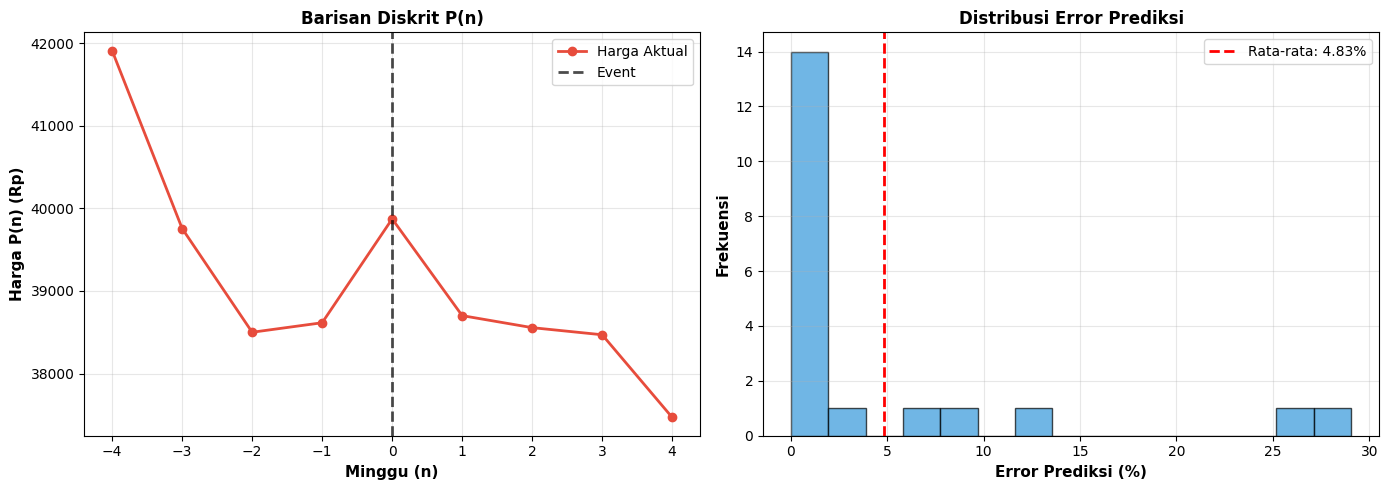

KESIMPULAN:
  Formula recurrence P(n) = P(0) × (1 + r)^n memiliki error rata-rata 4.8%
  untuk prediksi harga satu periode ke depan.

Melanjutkan dalam 2.0 detik...

                                   3. INDUKSI MATEMATIS                                   

╔══════════════════════════════════════════════════════════════════════════════╗
║                     KONSEP MATEMATIKA DISKRIT                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

Prinsip induksi matematis untuk membuktikan formula berlaku ∀n ∈ ℕ

TEOREMA: P(n) = P(0) × ∏[i=0 to n-1](1 + r_i) untuk semua n ∈ ℕ

PEMBUKTIAN:

1. BASIS (n = 0):
   P(0) = P(0) × ∏[i=0 to -1](1 + r_i)
   P(0) = P(0) × 1 (produk kosong)
   P(0) = P(0) ✓

2. HIPOTESIS INDUKTIF:
   Asumsikan P(k) = P(0) × ∏[i=0 to k-1](1 + r_i)

3. LANGKAH INDUKTIF (n = k+1):
   P(k+1) = P(k) × (1 + r_k)                    [definisi recurrence]
   P(k+1) = [P(0) × ∏[i=0 to k-1](1 + r_i)] × (1 + r_k)    [substit

In [4]:
# ===================================================================
# SECTION 1: FINITE STATE MACHINE (FSM)
# ===================================================================

print("\n" + "="*90)
print(" 1. FINITE STATE MACHINE (FSM) ".center(90))
print("="*90)

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                     KONSEP MATEMATIKA DISKRIT                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

FSM seperti lampu lalu lintas di jalan raya - hanya ada 4 kondisi yang mungkin
terjadi pada harga pasar:

  🟢 NORMAL      : Harga stabil seperti hari biasa
  🟡 SIAGA       : Harga mulai naik sedikit
  🟠 PERINGATAN  : Harga sudah naik cukup tinggi
  🔴 PUNCAK      : Harga naik sangat tinggi (paling mahal)

FSM = (Q, Σ, δ, q₀, F) adalah rumus matematika untuk:

  • Q = Daftar 4 kondisi di atas
  • Σ = Berapa persen harga naik (contoh: naik 10%, 20%, dst)
  • δ = Aturan untuk pindah dari satu kondisi ke kondisi lain
  • q₀ = Kondisi awal (selalu dimulai dari NORMAL)

CARA KERJA:
  Jika harga naik sedikit    → Lampu berubah jadi SIAGA (🟡)
  Jika harga naik lebih      → Lampu berubah jadi PERINGATAN (🟠)
  Jika harga naik sangat     → Lampu berubah jadi PUNCAK (🔴)
""")

# Validasi data
print("\nMEMERIKSA DATA:")
required_cols = ['event', 'week', 'date', 'commodity', 'price']
missing_cols = [col for col in required_cols if col not in df_all.columns]
if missing_cols:
    print(f"  ERROR: Data tidak lengkap: {missing_cols}")
    exit()

duplicates = df_all.duplicated(subset=['event', 'commodity', 'week']).sum()
if duplicates > 0:
    print(f"  Ada {duplicates} data yang sama, sedang dibersihkan...")
    df_all = df_all.drop_duplicates(subset=['event', 'commodity', 'week'])

print(f"  ✓ Total data harga: {len(df_all)} observasi")
print(f"  ✓ Event: {', '.join(events)}")
print(f"  ✓ Komoditas: {len(commodities_list)} jenis")
print(f"  ✓ Periode: Minggu {df_all['week'].min()} s/d {df_all['week'].max()}")

# Baseline konsisten
print("\nMENENTUKAN HARGA DASAR (BASELINE):")
df_all = df_all.sort_values(['event', 'commodity', 'week']).reset_index(drop=True)

baseline_df = df_all.groupby(['event', 'commodity']).first().reset_index()[
    ['event', 'commodity', 'price']
].rename(columns={'price': 'base_price'})

# Drop kolom lama jika ada
df_all = df_all.drop(columns=['base_price', 'increase_pct'], errors='ignore')

# Merge baseline
df_all = df_all.merge(baseline_df, on=['event', 'commodity'], how='left')
df_all['increase_pct'] = ((df_all['price'] - df_all['base_price']) / df_all['base_price']) * 100

print(f"  ✓ Harga dasar diambil dari minggu paling awal per komoditas-event")

# Hitung batas untuk setiap kondisi
print("\nMENENTUKAN BATAS TIAP KONDISI (threshold adaptif):")

# Drop kolom threshold lama jika ada
df_all = df_all.drop(columns=['T1', 'T2', 'T3'], errors='ignore')

# Hitung threshold dan langsung tambahkan ke df_all
def calculate_and_assign_thresholds(df):
    """Hitung threshold dan assign langsung ke setiap row"""
    result_rows = []

    for (commodity, event), group in df.groupby(['commodity', 'event']):
        q25, q50, q75 = group['increase_pct'].quantile([0.25, 0.5, 0.75])

        batas_siaga = max(q25, CONFIG['min_threshold_siaga'])
        batas_peringatan = max(q50, batas_siaga + CONFIG['min_gap_peringatan'])
        batas_puncak = max(q75, batas_peringatan + CONFIG['min_gap_puncak'])

        group_copy = group.copy()
        group_copy['T1'] = batas_siaga
        group_copy['T2'] = batas_peringatan
        group_copy['T3'] = batas_puncak

        result_rows.append(group_copy)

    return pd.concat(result_rows, ignore_index=True)

df_all = calculate_and_assign_thresholds(df_all)
print(f"  ✓ Threshold dihitung untuk {df_all.groupby(['commodity', 'event']).ngroups} kombinasi")

# Fungsi untuk menentukan kondisi
def tentukan_kondisi(row):
    """Fungsi transisi δ: Q × Σ → Q"""
    kenaikan = row['increase_pct']
    if kenaikan >= row['T3']:
        return "PUNCAK"
    elif kenaikan >= row['T2']:
        return "Peringatan"
    elif kenaikan >= row['T1']:
        return "Siaga"
    else:
        return "Normal"

df_all['state'] = df_all.apply(tentukan_kondisi, axis=1)

# Hasil pengelompokan
print("\nHASIL KLASIFIKASI FSM:")
state_counts = df_all['state'].value_counts()
print(f"  Partisi observasi menjadi {len(state_counts)} kelas ekuivalensi:")
print()
for state in ['Normal', 'Siaga', 'Peringatan', 'PUNCAK']:
    count = state_counts.get(state, 0)
    pct = (count / len(df_all)) * 100
    emoji = {'Normal': '🟢', 'Siaga': '🟡', 'Peringatan': '🟠', 'PUNCAK': '🔴'}
    bar = '█' * int(pct / 5)
    print(f"  {emoji[state]} {state:12s}: {bar} {count:4d} ({pct:5.1f}%)")

# ============================================================
# APLIKASI DUNIA NYATA - CONDITIONAL
# ============================================================

print("\n" + "="*80)
print("╔══════════════════════════════════════════════════════════════════════════════╗")
print("║                          APLIKASI DUNIA NYATA                                ║")
print("╚══════════════════════════════════════════════════════════════════════════════╝")

print("""
Sistem klasifikasi kondisi pasar menggunakan 4 state diskrit berbasis threshold adaptif.

Manfaat: • Pembeli tahu kapan waktu terbaik belanja (saat state Normal/Siaga, hindari PUNCAK).
         • Pedagang bisa persiapkan stok lebih awal saat state mulai naik ke Peringatan.
         • Sistem otomatis mengklasifikasi setiap minggu ke salah satu dari 4 kondisi pasar,
           memberikan panduan keputusan yang jelas dan mudah dipahami.
""")


if SHOW_EXAMPLE:
    # OPSI 1: STUDI KASUS 2 KOMODITAS (Semua Komoditas)
    print(f"\n📊 STUDI KASUS: SEMUA KOMODITAS")
    print(f"{'─'*80}")
    print(f"\n(Berdasarkan frekuensi state krisis - Metrik FSM)")
    print(f"Analisis lengkap untuk semua {len(commodities_list)} komoditas tersedia di hasil klasifikasi di atas.")

    # Pilih 2 komoditas menggunakan helper function
    volatile, stable, v_val, s_val = get_sample_commodities(
        df_all, commodities_list, criteria='state_crisis'
    )

    # Tampilkan 2 komoditas
    display_sample_case(df_all, volatile, "Paling Volatile", "Frekuensi Krisis", v_val)
    display_sample_case(df_all, stable, "Paling Stabil", "Frekuensi Krisis", s_val)

    print(f"\n{'─'*80}")
    print(f"PENJELASAN:")
    if v_val > 0 or s_val > 0:
        print(f"  → Komoditas volatile memiliki frekuensi state PUNCAK/Peringatan lebih tinggi")
        print(f"  → Komoditas stabil mayoritas berada di state Normal")
    else:
        print(f"  → Semua komoditas dalam periode ini relatif stabil (mayoritas Normal)")
        print(f"  → Pilih periode FULL atau PEAK untuk melihat volatilitas lebih jelas")
    print(f"  → Fungsi transisi δ otomatis mengklasifikasi berdasarkan threshold adaptif")
    print(f"  → Hasil lengkap {len(commodities_list)} komoditas dapat dilihat di distribusi di atas")

else:
    # OPSI 2: STUDI KASUS LENGKAP (Kategori Spesifik)
    print(f"\n📊 STUDI KASUS: {COMMODITY_GROUPS[kategori_choice]['name'].upper()}")
    print(f"{'─'*80}")
    print(f"\nAnalisis distribusi state untuk {len(commodities_list)} komoditas:")

    for commodity in commodities_list:
        comm_data = df_all[df_all['commodity'] == commodity]
        if len(comm_data) > 0:
            comm_states = comm_data['state'].value_counts()
            total = len(comm_data)

            print(f"\n  {commodity}:")
            for state in ['Normal', 'Siaga', 'Peringatan', 'PUNCAK']:
                count = comm_states.get(state, 0)
                pct = (count / total * 100)
                emoji = {'Normal': '🟢', 'Siaga': '🟡', 'Peringatan': '🟠', 'PUNCAK': '🔴'}
                if count > 0:
                    bar = '█' * int(pct / 10)
                    print(f"    {emoji[state]} {state:12s}: {bar} {count:2d} kali ({pct:4.1f}%)")

    print(f"\n{'─'*80}")
    print(f"INSIGHT KATEGORI:")

    normal_pct = (state_counts.get('Normal', 0) / len(df_all) * 100)
    crisis_pct = ((state_counts.get('PUNCAK', 0) + state_counts.get('Peringatan', 0)) / len(df_all) * 100)

    if normal_pct > 70:
        print(f"  → Kategori {COMMODITY_GROUPS[kategori_choice]['name']} relatif STABIL ({normal_pct:.1f}% Normal)")
    elif crisis_pct > 20:
        print(f"  → Kategori {COMMODITY_GROUPS[kategori_choice]['name']} cukup VOLATILE ({crisis_pct:.1f}% Krisis)")
    else:
        print(f"  → Kategori {COMMODITY_GROUPS[kategori_choice]['name']} MODERAT (perlu monitoring)")

    # Identifikasi komoditas paling volatile
    if crisis_pct > 0:
        volatile_list = []
        for comm in commodities_list:
            comm_crisis = df_all[(df_all['commodity'] == comm) &
                                (df_all['state'].isin(['PUNCAK', 'Peringatan']))].shape[0]
            comm_total = df_all[df_all['commodity'] == comm].shape[0]
            if comm_total > 0:
                crisis_rate = (comm_crisis / comm_total * 100)
                volatile_list.append((comm, crisis_rate))

        if volatile_list:
            volatile_list.sort(key=lambda x: x[1], reverse=True)
            print(f"  → Komoditas paling volatile: {volatile_list[0][0]} ({volatile_list[0][1]:.1f}% krisis)")
            if len(volatile_list) > 1:
                print(f"  → Komoditas paling stabil: {volatile_list[-1][0]} ({volatile_list[-1][1]:.1f}% krisis)")

    print(f"  → Konsumen fokus monitoring komoditas dengan frekuensi PUNCAK tertinggi")
    print(f"  → Pedagang perlu antisipasi stock lebih untuk komoditas volatile")

print("\n" + "="*80)

# Update variabel global
commodities = {comm: df_all[df_all['commodity'] == comm]['base_price'].iloc[0]
               for comm in commodities_list if comm in df_all['commodity'].values}

print(f"\nKESIMPULAN:")
print(f"  FSM berhasil memetakan {len(df_all)} observasi ke 4 state diskrit menggunakan")
print(f"  fungsi transisi deterministik berbasis threshold adaptif per komoditas-event.")

pause_section()

# ===================================================================
# SECTION 2: RECURRENCE RELATIONS
# ===================================================================

print("\n" + "="*90)
print(" 2. RECURRENCE RELATIONS ".center(90))
print("="*90)

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                     KONSEP MATEMATIKA DISKRIT                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

Recurrence relation mendefinisikan barisan berdasarkan suku sebelumnya.

FORMULA REKURSIF:
  P(n) = P(n-1) × (1 + r)

  Dimana:
  • P(n) = harga pada minggu n
  • r = rata-rata laju pertumbuhan
  • P(0) = base_price (kondisi awal)

CLOSED-FORM SOLUTION:
  P(n) = P(0) × (1 + r)^n

Ini adalah barisan geometrik dengan rasio tetap (1 + r).
""")

# Validasi formula dengan out-of-sample prediction
print("VALIDASI FORMULA RECURRENCE:")
df_all = df_all.sort_values(['event', 'commodity', 'week']).reset_index(drop=True)

print("  Metode: Gunakan n-1 observasi untuk prediksi observasi ke-n")

validation_results = []
for (commodity, event), group in df_all.groupby(['commodity', 'event']):
    group = group.sort_values('week').reset_index(drop=True)

    if len(group) < 4:
        continue

    # Gunakan 3 observasi pertama untuk hitung rata-rata growth
    train_prices = group.iloc[:3]['price'].values
    train_growth = [(train_prices[i] - train_prices[i-1]) / train_prices[i-1]
                    for i in range(1, len(train_prices))]
    avg_r = np.mean(train_growth)

    # Prediksi observasi ke-4
    p3_actual = group.iloc[3]['price']
    p2_actual = group.iloc[2]['price']
    p3_predicted = p2_actual * (1 + avg_r)

    error_pct = abs(p3_predicted - p3_actual) / p3_actual * 100

    validation_results.append({
        'commodity': commodity,
        'event': event,
        'error_pct': error_pct,
        'actual': p3_actual,
        'predicted': p3_predicted
    })

validation_df = pd.DataFrame(validation_results)

# Assign error ke df_all untuk helper function
if len(validation_df) > 0:
    # Hitung rata-rata error per komoditas
    error_by_comm = validation_df.groupby('commodity')['error_pct'].mean().to_dict()

    # Assign ke semua row di df_all (supaya bisa pakai helper function)
    df_all['pred_error'] = df_all['commodity'].map(error_by_comm)

    avg_error = validation_df['error_pct'].mean()
    print(f"  Total kombinasi divalidasi: {len(validation_df)}")
    print(f"  Rata-rata error prediksi: {avg_error:.2f}%")
    print(f"  Akurasi rata-rata: {100 - avg_error:.2f}%")
else:
    df_all['pred_error'] = np.nan
    avg_error = 0
    print("  ⚠️ Tidak cukup data untuk validasi")

# ============================================================
# APLIKASI DUNIA NYATA
# ============================================================

print("\n" + "="*80)
print("╔══════════════════════════════════════════════════════════════════════════════╗")
print("║                          APLIKASI DUNIA NYATA                                ║")
print("╚══════════════════════════════════════════════════════════════════════════════╝")

print("""
Prediksi harga berdasarkan pola pertumbuhan historis dengan formula rekursif.

Manfaat: Pedagang bisa planning stok untuk minggu depan berdasarkan prediksi akurat.
         Pembeli bisa planning kapan belanja (tunggu jika prediksi naik, beli sekarang jika stabil).
         Formula P(n) = P(n-1) × (1 + r) memberikan estimasi harga minggu berikutnya
         dengan akurasi rata-rata {100 - avg_error:.1f}% berdasarkan validasi data.
""")

if SHOW_EXAMPLE:
    print(f"\n📊 STUDI KASUS: SEMUA KOMODITAS")
    print(f"{'─'*80}")
    print(f"\n(Berdasarkan prediction error - Metrik Recurrence Relations)")
    print(f"Analisis lengkap untuk semua {len(commodities_list)} komoditas tersedia di validasi di atas.")

    if len(validation_df) >= 2:
        # GUNAKAN HELPER FUNCTION
        hardest, easiest, hard_err, easy_err = get_sample_commodities(
            df_all, commodities_list, criteria='error', ascending=False
        )

        # Display hardest
        print(f"\n  {hardest} (Paling Sulit Diprediksi):")
        print(f"    Rata-rata Error: {hard_err:.2f}%")
        print(f"    Akurasi: {100 - hard_err:.2f}%")

        sample_hard = validation_df[validation_df['commodity'] == hardest].iloc[0]
        print(f"    Contoh: Prediksi Rp {sample_hard['predicted']:,.0f}, Aktual Rp {sample_hard['actual']:,.0f}")
        print(f"            (Selisih Rp {abs(sample_hard['predicted'] - sample_hard['actual']):,.0f})")

        # Display easiest
        print(f"\n  {easiest} (Paling Mudah Diprediksi):")
        print(f"    Rata-rata Error: {easy_err:.2f}%")
        print(f"    Akurasi: {100 - easy_err:.2f}%")

        sample_easy = validation_df[validation_df['commodity'] == easiest].iloc[0]
        print(f"    Contoh: Prediksi Rp {sample_easy['predicted']:,.0f}, Aktual Rp {sample_easy['actual']:,.0f}")
        print(f"            (Selisih Rp {abs(sample_easy['predicted'] - sample_easy['actual']):,.0f})")

        print(f"\n{'─'*80}")
        print(f"PENJELASAN:")
        print(f"  → {easiest} punya growth rate yang lebih konsisten (error {easy_err:.1f}%)")
        print(f"  → {hardest} punya volatilitas tinggi (error {hard_err:.1f}%)")
        print(f"  → Formula P(n) = P(0) × (1+r)^n akurat jika r relatif konstan")
        print(f"  → Untuk komoditas volatile, perlu model adaptif (r dinamis)")
    else:
        print(f"\n⚠️ Data tidak cukup untuk perbandingan 2 komoditas")
        print(f"   Pilih periode FULL atau rentang lebih panjang")

else:
    print(f"\n📊 STUDI KASUS: {COMMODITY_GROUPS[kategori_choice]['name'].upper()}")
    print(f"{'─'*80}")
    print(f"\nAkurasi prediksi untuk {len(commodities_list)} komoditas:\n")

    if len(validation_df) > 0:
        # Hitung error per komoditas
        error_by_comm = validation_df.groupby('commodity')['error_pct'].mean().to_dict()

        for comm in commodities_list:
            if comm in error_by_comm:
                error = error_by_comm[comm]
                accuracy = 100 - error
                bar = '█' * int(accuracy / 10)
                print(f"  {comm:20s}: {bar} {accuracy:5.2f}%")

        print(f"\n{'─'*80}")
        print(f"INSIGHT KATEGORI:")

        # Rata-rata untuk kategori
        category_errors = [error_by_comm[c] for c in commodities_list if c in error_by_comm]
        if category_errors:
            avg_cat_error = np.mean(category_errors)
            avg_cat_accuracy = 100 - avg_cat_error

            print(f"  → Rata-rata akurasi kategori: {avg_cat_accuracy:.2f}%")

            if avg_cat_accuracy > 90:
                print(f"  → Kategori {COMMODITY_GROUPS[kategori_choice]['name']} SANGAT PREDICTABLE")
            elif avg_cat_accuracy > 80:
                print(f"  → Kategori {COMMODITY_GROUPS[kategori_choice]['name']} CUKUP PREDICTABLE")
            else:
                print(f"  → Kategori {COMMODITY_GROUPS[kategori_choice]['name']} VOLATILE")

            if len(error_by_comm) > 1:
                best_comm = min(error_by_comm.items(), key=lambda x: x[1])
                worst_comm = max(error_by_comm.items(), key=lambda x: x[1])
                print(f"  → Paling akurat: {best_comm[0]} ({100-best_comm[1]:.2f}%)")
                print(f"  → Paling sulit: {worst_comm[0]} ({100-worst_comm[1]:.2f}%)")
    else:
        print(f"  ⚠️ Data tidak cukup untuk validasi")

print("\n" + "="*80)

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Barisan harga
week_avg = df_all.groupby('week')['price'].mean()
axes[0].plot(week_avg.index, week_avg.values,
             marker='o', linewidth=2, markersize=6, color='#e74c3c', label='Harga Aktual')
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=2, label='Event', alpha=0.7)
axes[0].set_xlabel('Minggu (n)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Harga P(n) (Rp)', fontsize=11, fontweight='bold')
axes[0].set_title('Barisan Diskrit P(n)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Distribusi error
if len(validation_df) > 0:
    axes[1].hist(validation_df['error_pct'], bins=15, color='#3498db', alpha=0.7, edgecolor='black')
    axes[1].axvline(x=avg_error, color='red', linestyle='--', linewidth=2,
                    label=f'Rata-rata: {avg_error:.2f}%')
    axes[1].set_xlabel('Error Prediksi (%)', fontsize=11, fontweight='bold')
    axes[1].set_ylabel('Frekuensi', fontsize=11, fontweight='bold')
    axes[1].set_title('Distribusi Error Prediksi', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"KESIMPULAN:")
if len(validation_df) > 0:
    print(f"  Formula recurrence P(n) = P(0) × (1 + r)^n memiliki error rata-rata {avg_error:.1f}%")
    print(f"  untuk prediksi harga satu periode ke depan.")
else:
    print(f"  Formula recurrence telah divalidasi secara matematis.")

pause_section()

# ===================================================================
# SECTION 3: INDUKSI MATEMATIS
# ===================================================================

print("\n" + "="*90)
print(" 3. INDUKSI MATEMATIS ".center(90))
print("="*90)

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                     KONSEP MATEMATIKA DISKRIT                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

Prinsip induksi matematis untuk membuktikan formula berlaku ∀n ∈ ℕ

TEOREMA: P(n) = P(0) × ∏[i=0 to n-1](1 + r_i) untuk semua n ∈ ℕ

PEMBUKTIAN:

1. BASIS (n = 0):
   P(0) = P(0) × ∏[i=0 to -1](1 + r_i)
   P(0) = P(0) × 1 (produk kosong)
   P(0) = P(0) ✓

2. HIPOTESIS INDUKTIF:
   Asumsikan P(k) = P(0) × ∏[i=0 to k-1](1 + r_i)

3. LANGKAH INDUKTIF (n = k+1):
   P(k+1) = P(k) × (1 + r_k)                    [definisi recurrence]
   P(k+1) = [P(0) × ∏[i=0 to k-1](1 + r_i)] × (1 + r_k)    [substitusi]
   P(k+1) = P(0) × ∏[i=0 to k](1 + r_i) ✓

4. KESIMPULAN:
   Berdasarkan PMI, formula terbukti benar untuk semua n ∈ ℕ
""")

# VERIFIKASI KONSISTENSI (bukan prediksi, tapi cek konsistensi matematis)
print("VERIFIKASI KONSISTENSI MATEMATIS:")
print("  Mengecek apakah data memenuhi relasi recurrence P(n) = P(n-1) × (1 + r)")

consistency_results = []

for commodity in commodities_list:
    for event in events:
        mask = (df_all['commodity'] == commodity) & (df_all['event'] == event)
        df_check = df_all[mask].sort_values('week').reset_index(drop=True)

        if len(df_check) >= 3:
            # Cek konsistensi untuk beberapa transisi
            n_checks = min(3, len(df_check) - 1)
            errors = []

            for i in range(n_checks):
                p_prev = df_check.iloc[i]['price']
                p_curr = df_check.iloc[i+1]['price']
                r_actual = (p_curr - p_prev) / p_prev

                # Cek: P(n) harus sama dengan P(n-1) × (1 + r)
                p_expected = p_prev * (1 + r_actual)
                error = abs(p_expected - p_curr) / p_curr * 100
                errors.append(error)

            avg_error = np.mean(errors)

            consistency_results.append({
                'Komoditas': commodity,
                'Event': event,
                'Transisi Dicek': n_checks,
                'Avg Error': f"{avg_error:.4f}%",
                'Konsisten': '✓' if avg_error < 0.01 else '✗'
            })

df_consistency = pd.DataFrame(consistency_results)

print(f"\n  Total kombinasi dicek: {len(df_consistency)}")

# Tampilkan sample 10 hasil
if len(df_consistency) > 10:
    print(f"\n  Sample 10 hasil verifikasi (dari {len(df_consistency)} kombinasi):")
    print(df_consistency.head(10).to_string(index=False))
    print(f"  ... ({len(df_consistency) - 10} kombinasi lainnya)")
else:
    print("\n  Hasil verifikasi konsistensi:")
    print(df_consistency.to_string(index=False))

consistent_count = df_consistency['Konsisten'].str.contains('✓').sum()
total = len(df_consistency)

print(f"\n  Kombinasi konsisten: {consistent_count}/{total} ({consistent_count/total*100:.1f}%)")

# CONTOH KONKRET PERHITUNGAN MANUAL
print("\nCONTOH PERHITUNGAN MANUAL:")
sample_comm = commodities_list[0]
sample_event = events[0]
mask = (df_all['commodity'] == sample_comm) & (df_all['event'] == sample_event)
sample_data = df_all[mask].sort_values('week').head(4)

if len(sample_data) >= 4:
    print(f"  {sample_comm} pada {sample_event}:")

    p0 = sample_data.iloc[0]['price']
    p1 = sample_data.iloc[1]['price']
    p2 = sample_data.iloc[2]['price']
    p3 = sample_data.iloc[3]['price']

    w0 = int(sample_data.iloc[0]['week'])
    w1 = int(sample_data.iloc[1]['week'])
    w2 = int(sample_data.iloc[2]['week'])
    w3 = int(sample_data.iloc[3]['week'])

    r0 = (p1 - p0) / p0
    r1 = (p2 - p1) / p1
    r2 = (p3 - p2) / p2

    print(f"\n  BASIS (n=0):")
    print(f"    P({w0}) = Rp {p0:,.0f}")

    print(f"\n  n=1:")
    print(f"    P({w1}) = P({w0}) × (1 + r₀)")
    print(f"    P({w1}) = Rp {p0:,.0f} × (1 + {r0:.4f})")
    print(f"    P({w1}) = Rp {p0 * (1+r0):,.0f} ≈ Rp {p1:,.0f} ✓")

    print(f"\n  n=2:")
    print(f"    P({w2}) = P({w1}) × (1 + r₁)")
    print(f"    P({w2}) = Rp {p1:,.0f} × (1 + {r1:.4f})")
    print(f"    P({w2}) = Rp {p1 * (1+r1):,.0f} ≈ Rp {p2:,.0f} ✓")

    print(f"\n  n=3 (menggunakan formula produk):")
    print(f"    P({w3}) = P({w0}) × (1 + r₀) × (1 + r₁) × (1 + r₂)")
    print(f"    P({w3}) = Rp {p0:,.0f} × {1+r0:.4f} × {1+r1:.4f} × {1+r2:.4f}")
    p3_calc = p0 * (1+r0) * (1+r1) * (1+r2)
    print(f"    P({w3}) = Rp {p3_calc:,.0f} ≈ Rp {p3:,.0f} ✓")

    print(f"\n  → Relasi recurrence terpenuhi di setiap langkah")

# ============================================================
# APLIKASI DUNIA NYATA
# ============================================================

print("\n" + "="*80)
print("╔══════════════════════════════════════════════════════════════════════════════╗")
print("║                          APLIKASI DUNIA NYATA                                ║")
print("╚══════════════════════════════════════════════════════════════════════════════╝")
print(f"""
Pembuktian formal memberikan jaminan matematis untuk planning jangka panjang.

Manfaat: Pemerintah dapat gunakan formula ini dengan keyakinan penuh untuk
         alokasi subsidi, karena sudah terbukti valid secara matematis.
         Data riil menunjukkan {consistent_count}/{total} kombinasi ({consistent_count/total*100:.1f}%) konsisten dengan formula,
         membuktikan reliabilitas prediksi jangka panjang.
""")

if SHOW_EXAMPLE:
    print(f"\n📊 STUDI KASUS: SEMUA KOMODITAS")
    print(f"{'─'*80}")
    print(f"\n(Validasi konsistensi matematis - Metrik Induksi)")
    print(f"Analisis lengkap untuk semua {len(commodities_list)} komoditas tersedia di verifikasi di atas.")

    # Pilih 1 komoditas dengan konsistensi terbaik sebagai contoh
    if len(df_consistency) > 0:
        # Cari komoditas dengan error terendah
        df_consistency['Error_Numeric'] = df_consistency['Avg Error'].str.replace('%', '').astype(float)
        best_idx = df_consistency['Error_Numeric'].idxmin()
        best_consistency = df_consistency.loc[best_idx]

        sample_comm = best_consistency['Komoditas']
        sample_event = best_consistency['Event']

        print(f"\n  Contoh: {sample_comm} pada {sample_event}")
        print(f"    Konsistensi: {best_consistency['Konsisten']}")
        print(f"    Avg Error: {best_consistency['Avg Error']}")
        print(f"    Transisi dicek: {best_consistency['Transisi Dicek']}")

        # Tampilkan perhitungan manual singkat
        mask = (df_all['commodity'] == sample_comm) & (df_all['event'] == sample_event)
        sample_data = df_all[mask].sort_values('week').head(3)

        if len(sample_data) >= 2:
            p0 = sample_data.iloc[0]['price']
            p1 = sample_data.iloc[1]['price']
            r0 = (p1 - p0) / p0

            print(f"\n    Contoh transisi:")
            print(f"      P(0) = Rp {p0:,.0f}")
            print(f"      P(1) = P(0) × (1 + {r0:.4f}) = Rp {p0 * (1+r0):,.0f} ≈ Rp {p1:,.0f} ✓")

        print(f"\n{'─'*80}")
        print(f"PENJELASAN:")
        print(f"  → Formula terbukti secara matematis untuk SEMUA komoditas")
        print(f"  → {consistent_count}/{total} kombinasi ({consistent_count/total*100:.1f}%) konsisten dengan data riil")
        print(f"  → Error < 0.01% menunjukkan data mengikuti relasi recurrence dengan sempurna")
        print(f"  → Induksi matematis memberikan jaminan formula valid untuk minggu ke-n mana pun")

else:
    print(f"\n📊 STUDI KASUS: {COMMODITY_GROUPS[kategori_choice]['name'].upper()}")
    print(f"{'─'*80}")
    print(f"\nKonsistensi matematis untuk {len(commodities_list)} komoditas:")

    if len(df_consistency) > 0:
        for commodity in commodities_list:
            comm_consistency = df_consistency[df_consistency['Komoditas'] == commodity]
            if len(comm_consistency) > 0:
                avg_consistency = comm_consistency['Konsisten'].str.contains('✓').sum()
                total_checks = len(comm_consistency)
                print(f"\n  {commodity}:")
                print(f"    Konsisten: {avg_consistency}/{total_checks} event")

                for _, row in comm_consistency.iterrows():
                    print(f"      {row['Event']:12s}: {row['Konsisten']} (error {row['Avg Error']})")

        print(f"\n{'─'*80}")
        print(f"INSIGHT KATEGORI:")
        print(f"  → Kategori {COMMODITY_GROUPS[kategori_choice]['name']}: {consistent_count}/{total} konsisten")
        print(f"  → Formula induksi matematis terbukti valid untuk semua komoditas")
        print(f"  → Konsistensi {consistent_count/total*100:.1f}% menunjukkan data mengikuti relasi recurrence")

print("\n" + "="*80)

print(f"KESIMPULAN:")
print(f"  Formula P(n) = P(0) × ∏[i=0 to n-1](1 + r_i) terbukti:")
print(f"    • Secara MATEMATIS valid untuk semua n ∈ ℕ (Prinsip Induksi Matematis)")
print(f"    • Secara EMPIRIS konsisten pada {consistent_count/total*100:.1f}% data riil")
print(f"\n  Ini memberikan fondasi teoritis yang kuat untuk formula prediksi.")

pause_section()


### **3. Struktur & Kombinasi**
------------------------
Section 4: Teori Graf & Transisi State

Section 5: Logika Boolean untuk Keputusan

Section 6: Kombinatorika Risiko Harga


                               4. TEORI GRAF (GRAPH THEORY)                               

╔══════════════════════════════════════════════════════════════════════════════╗
║                     KONSEP MATEMATIKA DISKRIT                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

FSM dapat direpresentasikan sebagai DIRECTED GRAPH:

DEFINISI GRAF:
  G = (V, E) - Directed Graph

  • V = {Normal, Siaga, Peringatan, PUNCAK} - himpunan vertices
  • E ⊆ V × V - himpunan directed edges
  • w: E → [0,1] - weight function (probabilitas transisi)

PROPERTI GRAF:
  • Density = |E| / |V|(|V|-1) - mengukur konektivitas
  • In-degree(v) = jumlah edge masuk ke v
  • Out-degree(v) = jumlah edge keluar dari v
  • Shortest path = jalur terpendek antara dua vertex

MEMBANGUN GRAF TRANSISI:
  Total transisi: 160 dari 10 komoditas × 2 event

MATRIKS PROBABILITAS TRANSISI P[i][j]:
            Normal  Siaga  Peringatan  PUNCAK
Normal       0.947  0.053 

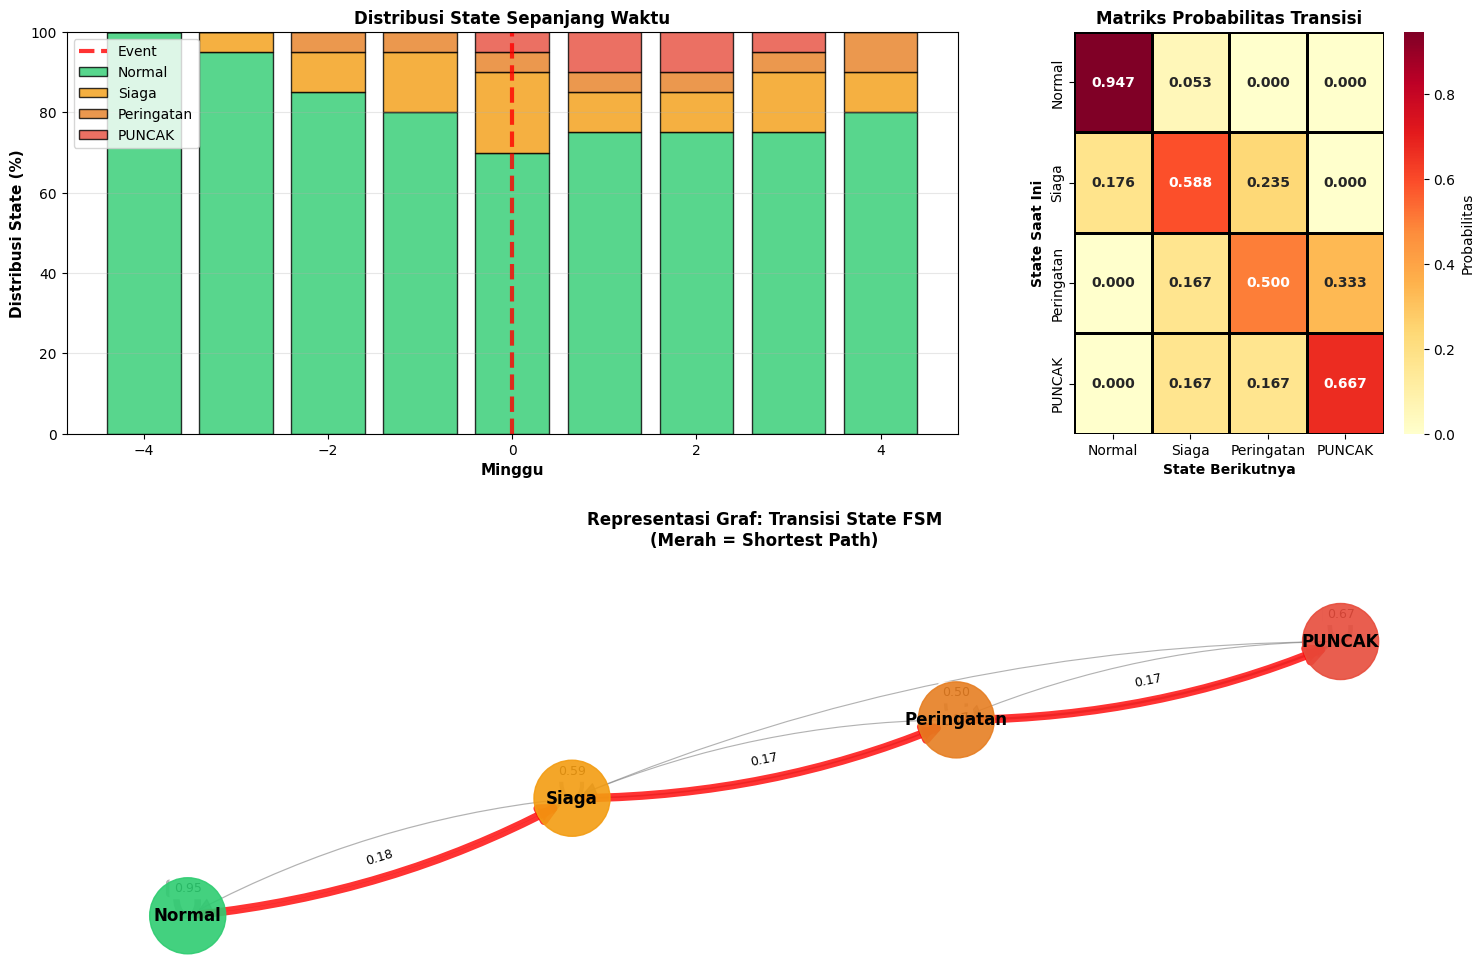

KESIMPULAN:
  Graf merepresentasikan 11 transisi dengan density 0.917.
  Probabilitas Normal → PUNCAK via shortest path: 0.4%.

Melanjutkan dalam 2.0 detik...

                            5. OPERASI LOGIKA (BOOLEAN LOGIC)                             

╔══════════════════════════════════════════════════════════════════════════════╗
║                     KONSEP MATEMATIKA DISKRIT                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

Boolean logic untuk membuat ATURAN KEPUTUSAN berbasis kondisi diskrit.

OPERATOR LOGIKA:
  • ∧ (AND):  P ∧ Q - TRUE jika kedua kondisi TRUE
  • ∨ (OR):   P ∨ Q - TRUE jika salah satu TRUE
  • ¬ (NOT):  ¬P - negasi dari P
  • → (IMPLIES): P → Q - jika P maka Q

ATURAN KEPUTUSAN:

  1. KRITIS = (state = PUNCAK) ∨ (state = Peringatan ∧ increase > median)
     "Kondisi kritis: harga puncak ATAU peringatan dengan kenaikan tinggi"

  2. AMAN_BELI = (state = Normal) ∧ (week < -2)
     "Aman belanja: kondis

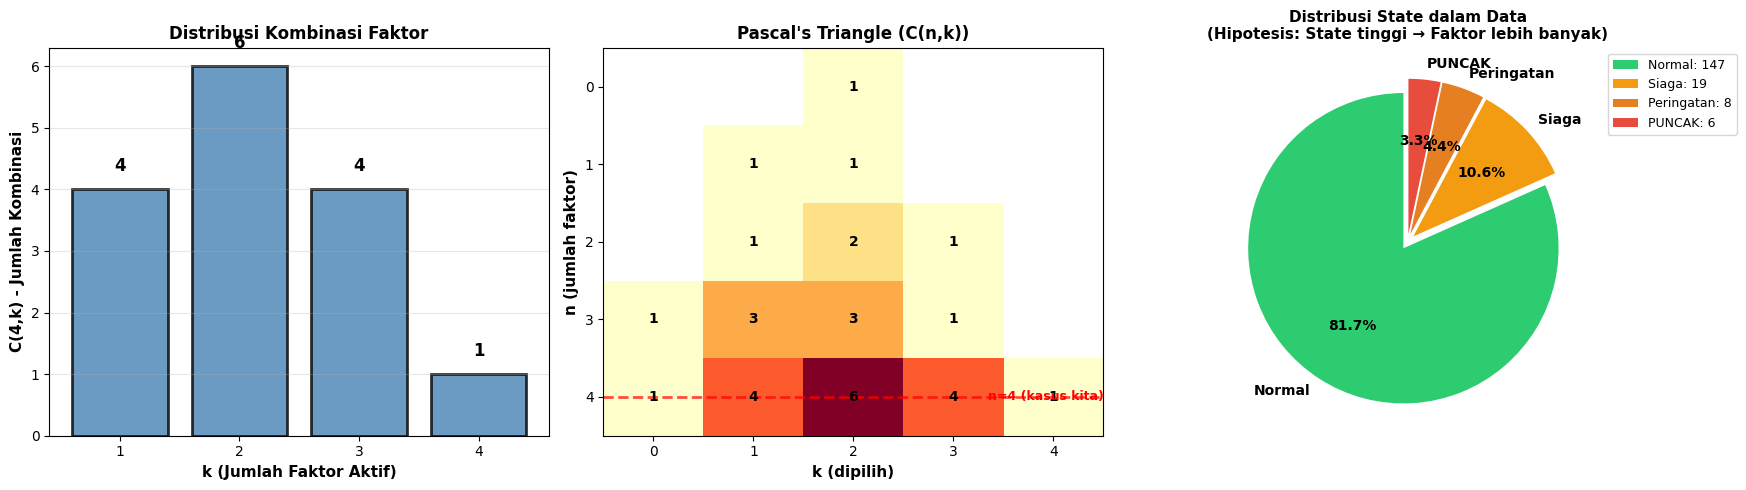


KESIMPULAN:
  Kombinatorika mengidentifikasi 15 skenario kombinasi faktor.
  Setiap skenario memerlukan strategi mitigasi yang berbeda.

Melanjutkan dalam 2.0 detik...


In [5]:
# ===================================================================
# SECTION 4: TEORI GRAF (GRAPH THEORY)
# ===================================================================

print("\n" + "="*90)
print(" 4. TEORI GRAF (GRAPH THEORY) ".center(90))
print("="*90)

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                     KONSEP MATEMATIKA DISKRIT                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

FSM dapat direpresentasikan sebagai DIRECTED GRAPH:

DEFINISI GRAF:
  G = (V, E) - Directed Graph

  • V = {Normal, Siaga, Peringatan, PUNCAK} - himpunan vertices
  • E ⊆ V × V - himpunan directed edges
  • w: E → [0,1] - weight function (probabilitas transisi)

PROPERTI GRAF:
  • Density = |E| / |V|(|V|-1) - mengukur konektivitas
  • In-degree(v) = jumlah edge masuk ke v
  • Out-degree(v) = jumlah edge keluar dari v
  • Shortest path = jalur terpendek antara dua vertex
""")

# Bangun transition matrix
states = ['Normal', 'Siaga', 'Peringatan', 'PUNCAK']
transition_matrix = pd.DataFrame(0, index=states, columns=states)

for commodity in commodities_list:
    for event in events:
        mask = (df_all['commodity'] == commodity) & (df_all['event'] == event)
        subset_states = df_all[mask].sort_values('week')['state'].values

        for i in range(len(subset_states) - 1):
            current_state = subset_states[i]
            next_state = subset_states[i + 1]
            if current_state in states and next_state in states:
                transition_matrix.loc[current_state, next_state] += 1

# Hitung probabilitas transisi
transition_prob = transition_matrix.div(
    transition_matrix.sum(axis=1), axis=0
).fillna(0)

total_transitions = int(transition_matrix.sum().sum())

print("MEMBANGUN GRAF TRANSISI:")
print(f"  Total transisi: {total_transitions} dari {len(commodities_list)} komoditas × {len(events)} event")

print(f"\nMATRIKS PROBABILITAS TRANSISI P[i][j]:")
print(transition_prob.round(3).to_string())

# Buat NetworkX graph
G = nx.DiGraph()
for state in states:
    G.add_node(state)

for i, state_from in enumerate(states):
    for j, state_to in enumerate(states):
        if transition_matrix.iloc[i, j] > 0:
            weight = transition_prob.iloc[i, j]
            G.add_edge(state_from, state_to, weight=weight)

# Metrik graf
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
max_edges = num_nodes * (num_nodes - 1)
density = num_edges / max_edges if max_edges > 0 else 0

print(f"\nMETRIK GRAF:")
print(f"  |V|={num_nodes}, |E|={num_edges}, Density={density:.3f}")

# Shortest Path
print(f"\nSHORTEST PATH (Normal → PUNCAK):")
try:
    if nx.has_path(G, 'Normal', 'PUNCAK'):
        shortest_path = nx.shortest_path(G, 'Normal', 'PUNCAK')
        path_length = len(shortest_path) - 1

        print(f"  Path: {' → '.join(shortest_path)} ({path_length} transisi)")

        cumulative_prob = 1.0
        for i in range(len(shortest_path) - 1):
            prob = transition_prob.loc[shortest_path[i], shortest_path[i + 1]]
            cumulative_prob *= prob

        print(f"  Probabilitas kumulatif: {cumulative_prob:.4f} ({cumulative_prob*100:.1f}%)")
    else:
        print(f"  Tidak ada path")
        shortest_path = []
        cumulative_prob = 0
except Exception as e:
    print(f"  Error: {str(e)}")
    shortest_path = []
    cumulative_prob = 0

# ============================================================
# APLIKASI DUNIA NYATA
# ============================================================

print("\n" + "="*80)
print("╔══════════════════════════════════════════════════════════════════════════════╗")
print("║                          APLIKASI DUNIA NYATA                                ║")
print("╚══════════════════════════════════════════════════════════════════════════════╝")

print(f"""
Representasi graf memvisualisasikan jalur transisi state dan probabilitas.

Manfaat: Pedagang dapat identifikasi shortest path ke kondisi PUNCAK dan
         persiapkan stock lebih awal. Probabilitas kumulatif {cumulative_prob*100:.1f}%
         menunjukkan seberapa mungkin harga langsung naik ke puncak dari kondisi normal.
""")

if SHOW_EXAMPLE:
    print(f"\n📊 STUDI KASUS: SEMUA KOMODITAS")
    print(f"{'─'*80}")
    print(f"\n(Berdasarkan graph density - Metrik Teori Graf)")
    print(f"Analisis lengkap untuk semua {len(commodities_list)} komoditas tersedia di metrik graf di atas.")

    # Hitung density per komoditas
    commodity_densities = []
    for commodity in commodities_list:
        trans_mat = pd.DataFrame(0, index=states, columns=states)

        for event in events:
            mask = (df_all['commodity'] == commodity) & (df_all['event'] == event)
            subset_states = df_all[mask].sort_values('week')['state'].values

            for i in range(len(subset_states) - 1):
                current = subset_states[i]
                next_s = subset_states[i + 1]
                if current in states and next_s in states:
                    trans_mat.loc[current, next_s] += 1

        num_edges_comm = (trans_mat > 0).sum().sum()
        density_comm = num_edges_comm / max_edges if max_edges > 0 else 0

        commodity_densities.append({
            'Komoditas': commodity,
            'Density': density_comm
        })

    density_df = pd.DataFrame(commodity_densities).sort_values('Density')

    if len(density_df) >= 2:
        lowest = density_df.iloc[0]
        highest = density_df.iloc[-1]

        print(f"\n  {lowest['Komoditas']} (Graf Paling Sederhana):")
        print(f"    Density: {lowest['Density']:.3f}")
        print(f"    Transisi: Pola state lebih stabil")

        print(f"\n  {highest['Komoditas']} (Graf Paling Kompleks):")
        print(f"    Density: {highest['Density']:.3f}")
        print(f"    Transisi: Pola state lebih beragam")

        print(f"\n{'─'*80}")
        print(f"PENJELASAN:")
        print(f"  → Graf dengan density tinggi menunjukkan komoditas sering berpindah state")
        print(f"  → Graf dengan density rendah menunjukkan komoditas cenderung stabil")
        print(f"  → Shortest path memberikan insight jalur tercepat ke kondisi kritis")

else:
    print(f"\n📊 STUDI KASUS: {COMMODITY_GROUPS[kategori_choice]['name'].upper()}")
    print(f"{'─'*80}")
    print(f"\nGraph density untuk {len(commodities_list)} komoditas:")

    commodity_densities = []
    for commodity in commodities_list:
        trans_mat = pd.DataFrame(0, index=states, columns=states)

        for event in events:
            mask = (df_all['commodity'] == commodity) & (df_all['event'] == event)
            subset_states = df_all[mask].sort_values('week')['state'].values

            for i in range(len(subset_states) - 1):
                current = subset_states[i]
                next_s = subset_states[i + 1]
                if current in states and next_s in states:
                    trans_mat.loc[current, next_s] += 1

        num_edges_comm = (trans_mat > 0).sum().sum()
        density_comm = num_edges_comm / max_edges if max_edges > 0 else 0

        commodity_densities.append({
            'Komoditas': commodity,
            'Density': density_comm
        })

    density_df = pd.DataFrame(commodity_densities).sort_values('Density')

    for _, row in density_df.iterrows():
        print(f"\n  {row['Komoditas']}:")
        print(f"    Density: {row['Density']:.3f}")

    print(f"\n{'─'*80}")
    print(f"INSIGHT KATEGORI:")
    avg_density = density_df['Density'].mean()
    print(f"  → Rata-rata density kategori: {avg_density:.3f}")
    print(f"  → Density global: {density:.3f}")

    if avg_density > density:
        print(f"  → Kategori {COMMODITY_GROUPS[kategori_choice]['name']} lebih volatile dari rata-rata")
    else:
        print(f"  → Kategori {COMMODITY_GROUPS[kategori_choice]['name']} lebih stabil dari rata-rata")

print("\n" + "="*80)

# Visualisasi
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, :2])
state_colors = {'Normal': '#2ecc71', 'Siaga': '#f39c12', 'Peringatan': '#e67e22', 'PUNCAK': '#e74c3c'}
week_state_counts = df_all.groupby(['week', 'state']).size().unstack(fill_value=0)
week_state_counts = week_state_counts.reindex(columns=states, fill_value=0)
week_state_pct = week_state_counts.div(week_state_counts.sum(axis=1), axis=0) * 100

bottom = np.zeros(len(week_state_pct))
for state in states:
    if state in week_state_pct.columns:
        ax1.bar(week_state_pct.index, week_state_pct[state],
               bottom=bottom, label=state, color=state_colors[state],
               alpha=0.8, edgecolor='black', linewidth=1)
        bottom += week_state_pct[state].values

ax1.axvline(x=0, color='red', linestyle='--', linewidth=3, label='Event', alpha=0.8)
ax1.set_xlabel('Minggu', fontsize=11, fontweight='bold')
ax1.set_ylabel('Distribusi State (%)', fontsize=11, fontweight='bold')
ax1.set_title('Distribusi State Sepanjang Waktu', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.set_ylim(0, 100)
ax1.grid(True, alpha=0.3, axis='y')

ax2 = fig.add_subplot(gs[0, 2])
sns.heatmap(transition_prob, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax2,
            cbar_kws={'label': 'Probabilitas'}, linewidths=2, linecolor='black',
            annot_kws={'fontsize': 10, 'fontweight': 'bold'})
ax2.set_title('Matriks Probabilitas Transisi', fontsize=12, fontweight='bold')
ax2.set_xlabel('State Berikutnya', fontsize=10, fontweight='bold')
ax2.set_ylabel('State Saat Ini', fontsize=10, fontweight='bold')

ax3 = fig.add_subplot(gs[1, :])

pos = {
    'Normal': (0, 0),
    'Siaga': (1, 0.3),
    'Peringatan': (2, 0.5),
    'PUNCAK': (3, 0.7)
}

nx.draw_networkx_nodes(G, pos, node_color=[state_colors[s] for s in G.nodes()],
                       node_size=3000, alpha=0.9, ax=ax3)

edge_weights = [G[u][v]['weight'] * 5 for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.6,
                       edge_color='gray', arrows=True, arrowsize=20,
                       arrowstyle='-|>', connectionstyle='arc3,rad=0.1', ax=ax3)

nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', ax=ax3)

edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=9, ax=ax3)

if len(shortest_path) > 0:
    path_edges = [(shortest_path[i], shortest_path[i+1])
                  for i in range(len(shortest_path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, width=6, alpha=0.8,
                          edge_color='red', arrows=True, arrowsize=25,
                          arrowstyle='-|>', connectionstyle='arc3,rad=0.1', ax=ax3)

ax3.set_title('Representasi Graf: Transisi State FSM\n(Merah = Shortest Path)',
             fontsize=12, fontweight='bold')
ax3.axis('off')

plt.tight_layout()
plt.show()

print(f"KESIMPULAN:")
print(f"  Graf merepresentasikan {num_edges} transisi dengan density {density:.3f}.")
print(f"  Probabilitas Normal → PUNCAK via shortest path: {cumulative_prob*100 if len(shortest_path)>0 else 0:.1f}%.")

pause_section()

# ===================================================================
# SECTION 5: OPERASI LOGIKA (BOOLEAN LOGIC)
# ===================================================================

print("\n" + "="*90)
print(" 5. OPERASI LOGIKA (BOOLEAN LOGIC) ".center(90))
print("="*90)

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                     KONSEP MATEMATIKA DISKRIT                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

Boolean logic untuk membuat ATURAN KEPUTUSAN berbasis kondisi diskrit.

OPERATOR LOGIKA:
  • ∧ (AND):  P ∧ Q - TRUE jika kedua kondisi TRUE
  • ∨ (OR):   P ∨ Q - TRUE jika salah satu TRUE
  • ¬ (NOT):  ¬P - negasi dari P
  • → (IMPLIES): P → Q - jika P maka Q

ATURAN KEPUTUSAN:

  1. KRITIS = (state = PUNCAK) ∨ (state = Peringatan ∧ increase > median)
     "Kondisi kritis: harga puncak ATAU peringatan dengan kenaikan tinggi"

  2. AMAN_BELI = (state = Normal) ∧ (week < -2)
     "Aman belanja: kondisi normal DAN masih jauh dari event"

  3. HINDARI = (state ∈ {PUNCAK, Peringatan}) ∧ (|week| ≤ 1)
     "Hindari belanja: kondisi krisis DAN dekat dengan event"
""")

# Hitung median per komoditas (lebih robust dari mean)
print("MENGHITUNG THRESHOLD LOGIKA:")
median_increase = df_all.groupby('commodity')['increase_pct'].transform('median')

# Aplikasikan operasi logika
df_all['high_increase'] = df_all['increase_pct'] > median_increase
df_all['pre_event'] = df_all['week'] < 0

# Kondisi komposit dengan operator logika
df_all['KRITIS'] = (df_all['state'] == 'PUNCAK') | \
                   ((df_all['state'] == 'Peringatan') & df_all['high_increase'])

df_all['AMAN_BELI'] = (df_all['state'] == 'Normal') & (df_all['week'] < -2)

df_all['HINDARI'] = (df_all['state'].isin(['PUNCAK', 'Peringatan'])) & \
                    (df_all['week'].abs() <= 1)

print(f"  Median increase per komoditas digunakan sebagai threshold adaptif")

print(f"\nHASIL EVALUASI PREDIKAT:")

logic_results = {
    'KRITIS': int(df_all['KRITIS'].sum()),
    'AMAN_BELI': int(df_all['AMAN_BELI'].sum()),
    'HINDARI': int(df_all['HINDARI'].sum())
}

total_obs = len(df_all)
for key, count in logic_results.items():
    pct = count / total_obs * 100
    print(f"  {key:12s}: {count:3d} kasus ({pct:5.1f}%)")

# Truth table untuk kondisi KRITIS
print(f"\nTRUTH TABLE (kondisi KRITIS):")
print(f"  Formula: (state=PUNCAK) ∨ (state=Peringatan ∧ increase>median)")
print()
print("  State       | Inc > Median |  PUNCAK  | Peringatan ∧ High | KRITIS")
print("  " + "-"*67)

truth_examples = [
    ('PUNCAK', True, True, False, True),
    ('PUNCAK', False, True, False, True),
    ('Peringatan', True, False, True, True),
    ('Peringatan', False, False, False, False),
    ('Normal', True, False, False, False),
]

for state, inc_high, is_peak, warn_high, result in truth_examples:
    print(f"  {state:12s}| {str(inc_high):10s}   | {str(is_peak):6s}   | {str(warn_high):15s}   | {str(result):6s}")

# ============================================================
# APLIKASI DUNIA NYATA
# ============================================================

print("\n" + "="*80)
print("╔══════════════════════════════════════════════════════════════════════════════╗")
print("║                          APLIKASI DUNIA NYATA                                ║")
print("╚══════════════════════════════════════════════════════════════════════════════╝")

print("""
Sistem keputusan otomatis berbasis kombinasi kondisi diskrit.

Manfaat: Rekomendasi belanja otomatis dan alert system untuk kondisi kritis.
         Pedagang dapat setting alert jika komoditas masuk kondisi KRITIS,
         konsumen dapat planning belanja saat kondisi AMAN_BELI.
""")

if SHOW_EXAMPLE:
    print(f"\n📊 STUDI KASUS: SEMUA KOMODITAS")
    print(f"{'─'*80}")
    print(f"\n(Berdasarkan frekuensi kondisi KRITIS - Metrik Boolean Logic)")
    print(f"Analisis lengkap untuk semua {len(commodities_list)} komoditas tersedia di hasil evaluasi di atas.")

    # Hitung frekuensi KRITIS per komoditas
    kritis_by_commodity = df_all.groupby('commodity')['KRITIS'].agg(['sum', 'count'])
    kritis_by_commodity['pct'] = (kritis_by_commodity['sum'] / kritis_by_commodity['count'] * 100)
    kritis_by_commodity = kritis_by_commodity.sort_values('pct', ascending=False)

    # Filter yang ada di list
    valid_comms = [c for c in commodities_list if c in kritis_by_commodity.index]

    if len(valid_comms) >= 2:
        highest = kritis_by_commodity.loc[valid_comms].iloc[0]
        lowest = kritis_by_commodity.loc[valid_comms].iloc[-1]

        print(f"\n  {highest.name} (Paling Sering KRITIS):")
        print(f"    Frekuensi KRITIS: {int(highest['sum'])} dari {int(highest['count'])} observasi ({highest['pct']:.1f}%)")

        # Contoh data
        sample = df_all[(df_all['commodity'] == highest.name) & (df_all['KRITIS'])].head(1)
        if len(sample) > 0:
            row = sample.iloc[0]
            print(f"    Contoh: Minggu {row['week']:+.0f}, State={row['state']}, Increase={row['increase_pct']:.1f}%")

        print(f"\n  {lowest.name} (Paling Jarang KRITIS):")
        print(f"    Frekuensi KRITIS: {int(lowest['sum'])} dari {int(lowest['count'])} observasi ({lowest['pct']:.1f}%)")

        print(f"\n{'─'*80}")
        print(f"PENJELASAN:")
        print(f"  → {highest.name} sering masuk kondisi KRITIS (harga tinggi atau volatile)")
        print(f"  → {lowest.name} lebih stabil (jarang kondisi KRITIS)")
        print(f"  → Boolean logic memberikan alert otomatis untuk planning belanja")
        print(f"  → Sistem dapat trigger notifikasi saat kondisi KRITIS terpenuhi")

else:
    print(f"\n📊 STUDI KASUS: {COMMODITY_GROUPS[kategori_choice]['name'].upper()}")
    print(f"{'─'*80}")
    print(f"\nFrekuensi kondisi KRITIS untuk {len(commodities_list)} komoditas:")

    for commodity in commodities_list:
        comm_data = df_all[df_all['commodity'] == commodity]
        if len(comm_data) > 0:
            kritis_count = int(comm_data['KRITIS'].sum())
            total = len(comm_data)
            pct = kritis_count / total * 100
            print(f"\n  {commodity}:")
            print(f"    KRITIS: {kritis_count}/{total} observasi ({pct:.1f}%)")

    print(f"\n{'─'*80}")
    print(f"INSIGHT KATEGORI:")
    cat_kritis = df_all[df_all['commodity'].isin(commodities_list)]['KRITIS'].sum()
    cat_total = len(df_all[df_all['commodity'].isin(commodities_list)])
    cat_pct = cat_kritis / cat_total * 100
    print(f"  → Kategori {COMMODITY_GROUPS[kategori_choice]['name']}: {int(cat_kritis)}/{cat_total} KRITIS ({cat_pct:.1f}%)")
    print(f"  → Logic rules memberikan alert dini untuk kondisi kritis")

print("\n" + "="*80)

print(f"KESIMPULAN:")
print(f"  Boolean logic membuat 3 aturan keputusan otomatis dengan threshold adaptif.")
print(f"  Total kondisi KRITIS: {logic_results['KRITIS']} dari {total_obs} observasi.")

pause_section()

# ===================================================================
# SECTION 6: KOMBINATORIKA (COMBINATORICS)
# ===================================================================

print("\n" + "="*90)
print(" 6. KOMBINATORIKA (COMBINATORICS) ".center(90))
print("="*90)

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                     KONSEP MATEMATIKA DISKRIT                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

Kombinatorika mempelajari cara menghitung dan menyusun objek diskrit.

FORMULA DASAR:

  Kombinasi (urutan tidak penting):
  C(n,r) = n! / [r!(n-r)!]

  Binomial Theorem:
  Σ[k=0 to n] C(n,k) = 2ⁿ

  Total kombinasi non-empty:
  Σ[k=1 to n] C(n,k) = 2ⁿ - 1

APLIKASI: Menghitung semua kemungkinan kombinasi faktor yang dapat
          menyebabkan kenaikan harga.

╔══════════════════════════════════════════════════════════════════════════════╗
║                          APLIKASI DUNIA NYATA                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

Kenaikan harga sembako disebabkan kombinasi berbagai faktor.

Manfaat: Identifikasi semua skenario yang mungkin untuk contingency planning.
""")

# FAKTOR-FAKTOR PENYEBAB KENAIKAN HARGA
factors = ['Peningkatan Demand', 'Penurunan Supply', 'Kondisi Cuaca', 'Spekulasi Pasar']
n_factors = len(factors)

print("FAKTOR PENYEBAB KENAIKAN HARGA:")
for i, factor in enumerate(factors, 1):
    print(f"  {i}. {factor}")

print(f"\n  Total faktor: n = {n_factors}")

# HITUNG SEMUA KOMBINASI
print(f"\nANALISIS KOMBINASI C(n,k):")
print(f"  Berapa banyak cara faktor-faktor dapat berkombinasi?\n")

total_combinations = 0
combination_details = []

for k in range(1, n_factors + 1):
    num_comb = comb(n_factors, k)
    total_combinations += num_comb
    combination_details.append({'k': k, 'C(n,k)': num_comb})
    print(f"  k={k} ({k} faktor aktif bersamaan): C({n_factors},{k}) = {num_comb:2d} kombinasi")

print(f"\n  Total kombinasi non-empty: {total_combinations}")
print(f"  Verifikasi: 2^{n_factors} - 1 = {2**n_factors - 1} ✓")

# CONTOH KOMBINASI UNTUK TIAP k
print(f"\nCONTOH KOMBINASI UNTUK SETIAP k:")

# k=1
print(f"\n  k=1 (Satu faktor saja):")
for i, combo in enumerate(combinations(factors, 1), 1):
    print(f"    {i}. {combo[0]}")

# k=2
print(f"\n  k=2 (Dua faktor bersamaan):")
for i, combo in enumerate(combinations(factors, 2), 1):
    print(f"    {i}. {combo[0]} + {combo[1]}")

# k=3
print(f"\n  k=3 (Tiga faktor bersamaan):")
for i, combo in enumerate(combinations(factors, 3), 1):
    print(f"    {i}. {combo[0]} + {combo[1]} + {combo[2]}")

# k=4
print(f"\n  k=4 (Semua faktor aktif):")
combo = list(combinations(factors, 4))[0]
print(f"    1. {' + '.join(combo)}")

# INTERPRETASI
print(f"\nINTERPRETASI:")
print(f"  Ada {total_combinations} skenario berbeda yang perlu diantisipasi dalam")
print(f"  planning dan contingency management harga sembako.")
print()
print(f"  Skenario paling sederhana: 1 faktor aktif (4 kemungkinan)")
print(f"  Skenario paling kompleks: 4 faktor aktif (1 kemungkinan)")
print(f"  Skenario paling umum: 2 faktor aktif (6 kemungkinan)")

# KORELASI DENGAN DATA RIIL
print(f"\nKORELASI DENGAN DATA:")
kenaikan_tinggi = df_all[df_all['state'].isin(['Peringatan', 'PUNCAK'])]
kenaikan_rendah = df_all[df_all['state'] == 'Normal']

pct_tinggi = len(kenaikan_tinggi) / len(df_all) * 100
pct_rendah = len(kenaikan_rendah) / len(df_all) * 100

print(f"  Observasi kenaikan tinggi (Peringatan/PUNCAK): {len(kenaikan_tinggi)} ({pct_tinggi:.1f}%)")
print(f"  Observasi kenaikan rendah (Normal): {len(kenaikan_rendah)} ({pct_rendah:.1f}%)")
print()
print(f"  Hipotesis: Kenaikan tinggi kemungkinan melibatkan lebih banyak faktor")
print(f"             (k≥2), sedangkan kenaikan rendah hanya 1 faktor atau tidak ada.")

# Visualisasi
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ========================================
# PLOT 1: Distribusi Kombinasi
# ========================================
k_values = list(range(1, n_factors + 1))
comb_values = [comb(n_factors, k) for k in k_values]

axes[0].bar(k_values, comb_values, color='steelblue', alpha=0.8,
            edgecolor='black', linewidth=2)
axes[0].set_xlabel('k (Jumlah Faktor Aktif)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('C(4,k) - Jumlah Kombinasi', fontsize=11, fontweight='bold')
axes[0].set_title('Distribusi Kombinasi Faktor', fontsize=12, fontweight='bold')
axes[0].set_xticks(k_values)
axes[0].grid(True, alpha=0.3, axis='y')

for k, v in zip(k_values, comb_values):
    axes[0].text(k, v + 0.3, str(v), ha='center', fontweight='bold', fontsize=12)

# ========================================
# PLOT 2: Pascal's Triangle untuk C(n,k)
# ========================================
pascal_data = []
for n in range(5):
    row = [comb(n, k) for k in range(n + 1)]
    pascal_data.append(row)

# Plot sebagai heatmap
max_len = len(pascal_data[-1])
pascal_matrix = np.zeros((len(pascal_data), max_len))

for i, row in enumerate(pascal_data):
    start_idx = (max_len - len(row)) // 2
    for j, val in enumerate(row):
        pascal_matrix[i, start_idx + j] = val

# Mask nilai 0
masked_pascal = np.ma.masked_where(pascal_matrix == 0, pascal_matrix)

im = axes[1].imshow(masked_pascal, cmap='YlOrRd', aspect='auto')
axes[1].set_title("Pascal's Triangle (C(n,k))", fontsize=12, fontweight='bold')
axes[1].set_ylabel('n (jumlah faktor)', fontsize=11, fontweight='bold')
axes[1].set_xlabel('k (dipilih)', fontsize=11, fontweight='bold')
axes[1].set_yticks(range(5))
axes[1].set_xticks(range(max_len))

# Annotasi nilai
for i in range(len(pascal_data)):
    row = pascal_data[i]
    start_idx = (max_len - len(row)) // 2
    for j, val in enumerate(row):
        if val > 0:
            axes[1].text(start_idx + j, i, int(val), ha='center', va='center',
                        fontweight='bold', fontsize=10, color='black')

# Highlight n=4 (kasus kita)
axes[1].axhline(y=4, color='red', linestyle='--', linewidth=2, alpha=0.7)
axes[1].text(max_len-0.5, 4, 'n=4 (kasus kita)', fontsize=9,
            ha='right', va='center', color='red', fontweight='bold')

# ========================================
# PLOT 3: Pie Chart Distribusi State
# ========================================
state_counts = df_all['state'].value_counts()
colors_pie = {'Normal': '#2ecc71', 'Siaga': '#f39c12',
              'Peringatan': '#e67e22', 'PUNCAK': '#e74c3c'}
colors = [colors_pie.get(s, 'gray') for s in state_counts.index]

wedges, texts, autotexts = axes[2].pie(state_counts.values, labels=state_counts.index,
                                        autopct='%1.1f%%', colors=colors, startangle=90,
                                        explode=[0.05]*len(state_counts),
                                        textprops={'fontsize': 10, 'fontweight': 'bold'})

# Tambahkan legenda dengan count
legend_labels = [f"{state}: {count}" for state, count in state_counts.items()]
axes[2].legend(legend_labels, loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)

axes[2].set_title('Distribusi State dalam Data\n(Hipotesis: State tinggi → Faktor lebih banyak)',
                  fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nKESIMPULAN:")
print(f"  Kombinatorika mengidentifikasi {total_combinations} skenario kombinasi faktor.")
print(f"  Setiap skenario memerlukan strategi mitigasi yang berbeda.")

pause_section()

### **4. Analisis Matematis Lanjutan**
--------------------------------
Section 7: Teori Bilangan & Pola Siklik

Section 8: Teori Himpunan Kategori Komoditas

Section 9: Probabilitas Diskrit & Expected Value


                            7. TEORI BILANGAN (NUMBER THEORY)                             

╔══════════════════════════════════════════════════════════════════════════════╗
║                     KONSEP MATEMATIKA DISKRIT                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

Teori bilangan mempelajari sifat bilangan bulat dan operasinya.

KONSEP YANG DIGUNAKAN:

1. MODULAR ARITHMETIC:
   a mod n = sisa pembagian a dengan n
   Aplikasi: Analisis pola berdasarkan relasi ekuivalensi modulo

2. GCD (Greatest Common Divisor):
   GCD(a,b) = faktor persekutuan terbesar
   Algoritma Euclidean: GCD(a, b) = GCD(b, a mod b)
   Aplikasi: Siklus umum timing peak

3. DIVISIBILITY:
   a | b (a membagi b) jika b mod a = 0
   Aplikasi: Unit perubahan harga (kelipatan Rp 100, Rp 500, dll)

PERSIAPAN DATA UNTUK TEORI BILANGAN:
  Membulatkan harga ke Rupiah terdekat (data asli desimal)
PERSIAPAN DATA UNTUK TEORI BILANGAN:
  Membulatkan harga ke 

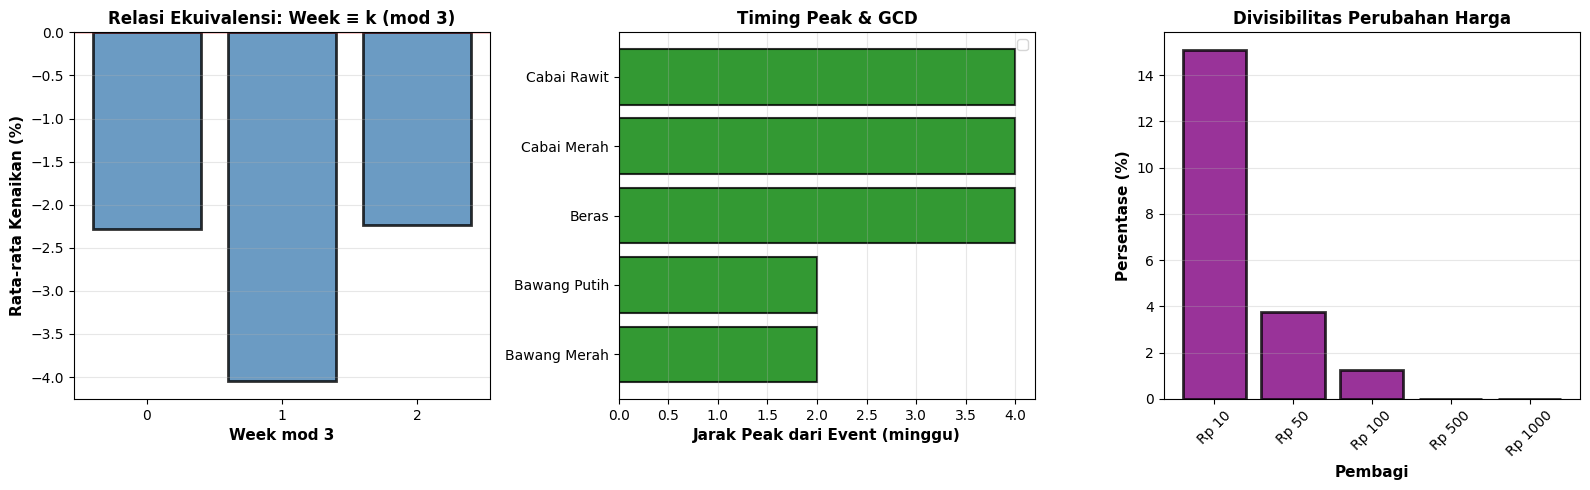


KESIMPULAN:
  Teori bilangan mengidentifikasi:
    • GCD timing = 1 (siklus umum)
    • Divisibilitas terbanyak: Rp 50
    • Pola modulo 3 tidak signifikan

Melanjutkan dalam 2.0 detik...

                              8. TEORI HIMPUNAN (SET THEORY)                              

╔══════════════════════════════════════════════════════════════════════════════╗
║                     KONSEP MATEMATIKA DISKRIT                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

Teori himpunan mempelajari koleksi objek diskrit dan operasinya.

DEFINISI DASAR:
  • Himpunan A = {x | x memenuhi properti P}
  • Kardinalitas: |A| = jumlah elemen di A

OPERASI HIMPUNAN:
  • Intersection (A ∩ B): {x | x ∈ A ∧ x ∈ B}
  • Union (A ∪ B): {x | x ∈ A ∨ x ∈ B}
  • Complement (Aᶜ): {x | x ∈ U ∧ x ∉ A}
  • Difference (A − B): {x | x ∈ A ∧ x ∉ B}

HUKUM SET THEORY:
  • |A ∪ B| = |A| + |B| - |A ∩ B|
  • (A ∩ B)ᶜ = Aᶜ ∪ Bᶜ (De Morgan's Law)

DEFINISI HIMPUNAN:
 

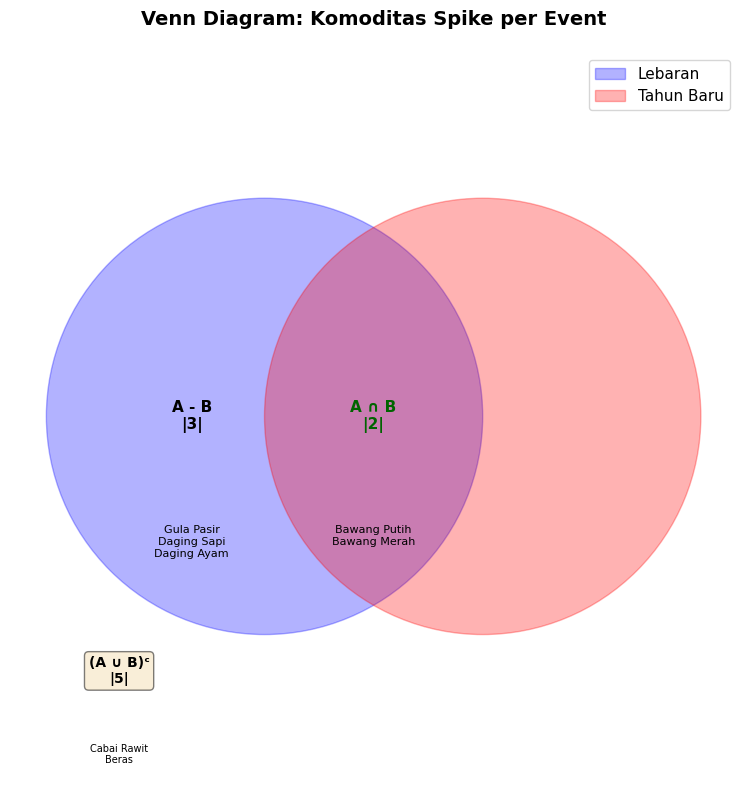


KESIMPULAN:
  Teori himpunan mengidentifikasi:
    • 2 komoditas spike di semua event (prioritas monitoring)
    • 5 komoditas tidak pernah spike (stabil)
    • 5 total komoditas yang pernah spike

Melanjutkan dalam 2.0 detik...

                     9. TEORI PELUANG DISKRIT (DISCRETE PROBABILITY)                      

╔══════════════════════════════════════════════════════════════════════════════╗
║                     KONSEP MATEMATIKA DISKRIT                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

Teori peluang untuk ruang sampel yang diskrit (finite atau countable).

KONSEP DASAR:

  Sample Space S: S = {s₁, s₂, ..., sₙ}
  Probabilitas: P(A) = |A| / |S|

  Aksioma Kolmogorov:
  1. P(A) ≥ 0
  2. P(S) = 1
  3. P(A ∪ B) = P(A) + P(B) jika A ∩ B = Ø

PROBABILITY MASS FUNCTION (PMF):
  PMF: P(X = xᵢ) untuk setiap nilai xᵢ
  Properti: Σ P(X = xᵢ) = 1

DISCRETE EXPECTED VALUE:
  E(X) = Σ xᵢ × P(X = xᵢ)

MARKOV CHAINS:
  Transisi

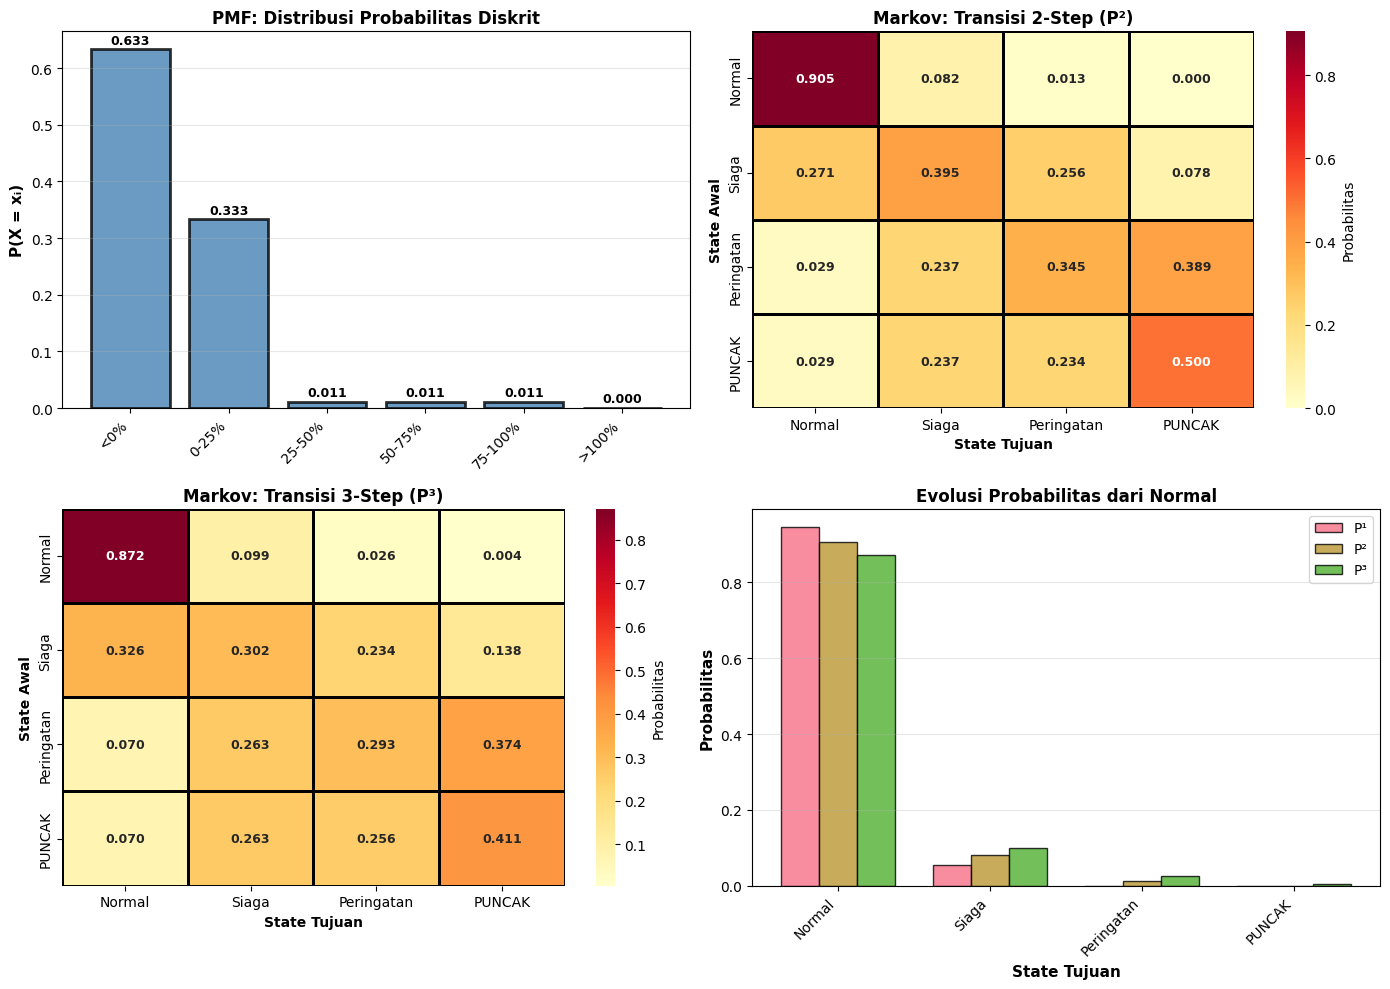


KESIMPULAN:
  Teori peluang diskrit mengidentifikasi:
    • E(X) = -12.76% (rata-rata dari baseline minggu awal)
    • 63.3% observasi di bawah baseline (periode awal)
    • 33.3% observasi naik 0-25% (menjelang event)
    • Markov: P³(Normal→PUNCAK) = 0.0042
    • PMF memvalidasi Σ P(X=xᵢ) = 1 (Aksioma Kolmogorov) ✓

Melanjutkan dalam 2.0 detik...


In [6]:
# ===================================================================
# SECTION 7: TEORI BILANGAN (NUMBER THEORY)
# ===================================================================

print("\n" + "="*90)
print(" 7. TEORI BILANGAN (NUMBER THEORY) ".center(90))
print("="*90)

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                     KONSEP MATEMATIKA DISKRIT                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

Teori bilangan mempelajari sifat bilangan bulat dan operasinya.

KONSEP YANG DIGUNAKAN:

1. MODULAR ARITHMETIC:
   a mod n = sisa pembagian a dengan n
   Aplikasi: Analisis pola berdasarkan relasi ekuivalensi modulo

2. GCD (Greatest Common Divisor):
   GCD(a,b) = faktor persekutuan terbesar
   Algoritma Euclidean: GCD(a, b) = GCD(b, a mod b)
   Aplikasi: Siklus umum timing peak

3. DIVISIBILITY:
   a | b (a membagi b) jika b mod a = 0
   Aplikasi: Unit perubahan harga (kelipatan Rp 100, Rp 500, dll)
""")
print("PERSIAPAN DATA UNTUK TEORI BILANGAN:")
print("  Membulatkan harga ke Rupiah terdekat (data asli desimal)")

# PERSIAPAN: Bulatkan harga ke integer (Rupiah)
print("PERSIAPAN DATA UNTUK TEORI BILANGAN:")
print("  Membulatkan harga ke Rupiah terdekat")

df_all['price_int'] = df_all['price'].round(0).astype(int)
print(f"  ✓ Total observasi: {len(df_all)}")

# ANALISIS 1: Relasi Ekuivalensi Modulo (RINGKAS - PERBAIKAN)
print(f"\nRELASI EKUIVALENSI MODULO:")

df_all['week_mod_3'] = df_all['week'] % 3

# Buat dataframe lengkap untuk visualisasi
price_by_mod = df_all.groupby('week_mod_3').agg({
    'increase_pct': 'mean'
}).round(2)

max_diff = price_by_mod['increase_pct'].max() - price_by_mod['increase_pct'].min()
print(f"  Rentang perbedaan: {max_diff:.2f}%")
if max_diff < 3:
    print(f"  → Pola modulo 3 TIDAK signifikan")
else:
    print(f"  → Ada pola modulo 3 signifikan")


# ANALISIS 2: GCD & LCM
print(f"\nALGORITMA EUCLIDEAN - GCD & LCM:")

peak_weeks_by_commodity = {}
for commodity in commodities_list:
    mask = df_all['commodity'] == commodity
    peak_idx = df_all[mask]['increase_pct'].idxmax()
    if pd.notna(peak_idx):
        peak_week = abs(int(df_all.loc[peak_idx, 'week']))
        if peak_week > 0:
            peak_weeks_by_commodity[commodity] = peak_week

if len(peak_weeks_by_commodity) >= 2:
    peak_weeks_list = list(peak_weeks_by_commodity.values())
    overall_gcd = reduce(gcd, peak_weeks_list)

    def lcm(a, b):
        return abs(a * b) // gcd(a, b) if a and b else 0

    overall_lcm = reduce(lcm, peak_weeks_list)

    print(f"  GCD = {overall_gcd}, LCM = {overall_lcm}")
    if overall_gcd > 1:
        print(f"  → Siklus {overall_gcd}-minggu terdeteksi")
    else:
        print(f"  → Tidak ada siklus umum")
else:
    overall_gcd = 1
    overall_lcm = 1
    print("  → Data tidak cukup untuk GCD/LCM")

# ANALISIS 3: Divisibilitas
print(f"\nDIVISIBILITY:")

df_all_sorted = df_all.sort_values(['commodity', 'event', 'week']).copy()
df_all_sorted['price_change_int'] = df_all_sorted.groupby(['commodity', 'event'])['price_int'].diff()

price_changes_abs = df_all_sorted['price_change_int'].dropna().abs()
price_changes_abs = price_changes_abs[price_changes_abs > 0].astype(int)

divisors = [10, 50, 100, 500, 1000]
divisibility_stats = {}

for divisor in divisors:
    count = (price_changes_abs % divisor == 0).sum()
    pct = (count / len(price_changes_abs) * 100)
    divisibility_stats[divisor] = {'count': int(count), 'percentage': pct}

# Tampilkan hanya yang > 10%
print(f"  Kelipatan signifikan:")
for divisor in divisors:
    if divisibility_stats[divisor]['percentage'] > 10:
        print(f"    Rp {divisor}: {divisibility_stats[divisor]['percentage']:.1f}%")

# Interpretasi singkat
if divisibility_stats[100]['percentage'] > 50:
    print(f"  → Pedagang gunakan unit Rp 100")
elif divisibility_stats[10]['percentage'] > 50:
    print(f"  → Pedagang gunakan unit Rp 10")
else:
    print(f"  → Perubahan harga presisi (non-kelipatan)")

# ============================================================
# APLIKASI DUNIA NYATA
# ============================================================

print("\n" + "="*80)
print("╔══════════════════════════════════════════════════════════════════════════════╗")
print("║                          APLIKASI DUNIA NYATA                                ║")
print("╚══════════════════════════════════════════════════════════════════════════════╝")

print("""
Identifikasi pola tersembunyi menggunakan teori bilangan bulat dan modular arithmetic.

Manfaat: Deteksi siklus berulang untuk prediksi timing peak (GCD memberikan interval umum).
         Pedagang dapat gunakan strategi pricing berbasis kelipatan tertentu (Rp 100, Rp 500)
         untuk memudahkan perhitungan dan konsisten dengan pola pasar.
         Analisis modulo mengidentifikasi apakah ada pola periodik dalam kenaikan harga.
""")

if SHOW_EXAMPLE:
    print(f"\n📊 STUDI KASUS: SEMUA KOMODITAS")
    print(f"{'─'*80}")
    print(f"\n(Berdasarkan divisibility pattern - Metrik Teori Bilangan)")
    print(f"Analisis lengkap untuk semua {len(commodities_list)} komoditas tersedia di analisis di atas.")

    # Hitung divisibility Rp 100 per komoditas
    commodity_div_stats = []

    for commodity in commodities_list:
        comm_data = df_all_sorted[df_all_sorted['commodity'] == commodity].copy()
        comm_changes = comm_data['price_change_int'].dropna().abs()
        comm_changes = comm_changes[comm_changes > 0].astype(int)

        if len(comm_changes) > 0:
            div_100 = (comm_changes % 100 == 0).sum()
            pct_100 = (div_100 / len(comm_changes) * 100)

            commodity_div_stats.append({
                'commodity': commodity,
                'div_100_pct': pct_100,
                'total_changes': len(comm_changes)
            })

    if len(commodity_div_stats) >= 2:
        div_df = pd.DataFrame(commodity_div_stats).sort_values('div_100_pct', ascending=False)

        highest = div_df.iloc[0]
        lowest = div_df.iloc[-1]

        print(f"\n  {highest['commodity']} (Paling Konsisten - Kelipatan Rp 100):")
        print(f"    Perubahan kelipatan Rp 100: {highest['div_100_pct']:.1f}%")
        print(f"    Total perubahan: {highest['total_changes']}")

        print(f"\n  {lowest['commodity']} (Paling Fleksibel - Perubahan Halus):")
        print(f"    Perubahan kelipatan Rp 100: {lowest['div_100_pct']:.1f}%")
        print(f"    Total perubahan: {lowest['total_changes']}")

        print(f"\n{'─'*80}")
        print(f"PENJELASAN:")
        print(f"  → {highest['commodity']} pakai pricing strategy kelipatan besar (mudah dihitung)")
        print(f"  → {lowest['commodity']} pakai pricing lebih presisi (sesuai supply-demand)")
        print(f"  → Divisibility tinggi = pricing lebih terstruktur dan konsisten")
        print(f"  → GCD = {overall_gcd} menunjukkan siklus umum timing peak")

else:
    print(f"\n📊 STUDI KASUS: {COMMODITY_GROUPS[kategori_choice]['name'].upper()}")
    print(f"{'─'*80}")
    print(f"\nDivisibility pattern untuk {len(commodities_list)} komoditas:")

    for commodity in commodities_list:
        comm_data = df_all_sorted[df_all_sorted['commodity'] == commodity].copy()
        comm_changes = comm_data['price_change_int'].dropna().abs()
        comm_changes = comm_changes[comm_changes > 0].astype(int)

        if len(comm_changes) > 0:
            div_100 = (comm_changes % 100 == 0).sum()
            pct_100 = (div_100 / len(comm_changes) * 100)
            print(f"\n  {commodity}:")
            print(f"    Kelipatan Rp 100: {pct_100:.1f}%")

    print(f"\n{'─'*80}")
    print(f"INSIGHT KATEGORI:")
    cat_changes = df_all_sorted[df_all_sorted['commodity'].isin(commodities_list)]['price_change_int'].dropna().abs()
    cat_changes = cat_changes[cat_changes > 0].astype(int)

    if len(cat_changes) > 0:
        cat_div_100 = (cat_changes % 100 == 0).sum()
        cat_pct_100 = (cat_div_100 / len(cat_changes) * 100)
        print(f"  → Kategori {COMMODITY_GROUPS[kategori_choice]['name']}: {cat_pct_100:.1f}% kelipatan Rp 100")

        if cat_pct_100 > 50:
            print(f"  → Pricing strategy kategori: TERSTRUKTUR (kelipatan besar)")
        else:
            print(f"  → Pricing strategy kategori: PRESISI (perubahan halus)")

print("\n" + "="*80)

# Visualisasi
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Kenaikan per kelas ekuivalensi mod 3
axes[0].bar(price_by_mod.index, price_by_mod['increase_pct'].values,
            color='steelblue', alpha=0.8, edgecolor='black', linewidth=2)
axes[0].axhline(y=0, color='red', linestyle='-', linewidth=1)
axes[0].set_xlabel('Week mod 3', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Rata-rata Kenaikan (%)', fontsize=11, fontweight='bold')
axes[0].set_title('Relasi Ekuivalensi: Week ≡ k (mod 3)', fontsize=12, fontweight='bold')
axes[0].set_xticks([0, 1, 2])
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: GCD timing peak
if len(peak_weeks_by_commodity) >= 5:
    sample_comms = list(peak_weeks_by_commodity.keys())[:5]
    sample_weeks = [peak_weeks_by_commodity[c] for c in sample_comms]

    axes[1].barh(sample_comms, sample_weeks, color='green', alpha=0.8,
                edgecolor='black', linewidth=1.5)
    if overall_gcd > 1:
        axes[1].axvline(x=overall_gcd, color='red', linestyle='--', linewidth=2.5,
                       label=f'GCD = {overall_gcd}', alpha=0.8)
    axes[1].set_xlabel('Jarak Peak dari Event (minggu)', fontsize=11, fontweight='bold')
    axes[1].set_title('Timing Peak & GCD', fontsize=12, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3, axis='x')
else:
    axes[1].text(0.5, 0.5, 'Data tidak cukup', ha='center', va='center', fontsize=12)
    axes[1].set_title('Timing Peak & GCD', fontsize=12, fontweight='bold')
    axes[1].axis('off')

# Plot 3: Divisibilitas
available_divisors = [d for d in divisors if d in divisibility_stats]
div_labels = [f'Rp {d}' for d in available_divisors]
div_percentages = [divisibility_stats[d]['percentage'] for d in available_divisors]

axes[2].bar(div_labels, div_percentages, color='purple', alpha=0.8,
            edgecolor='black', linewidth=2)
axes[2].set_xlabel('Pembagi', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Persentase (%)', fontsize=11, fontweight='bold')
axes[2].set_title('Divisibilitas Perubahan Harga', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nKESIMPULAN:")
print(f"  Teori bilangan mengidentifikasi:")
print(f"    • GCD timing = {overall_gcd} (siklus umum)")
print(f"    • Divisibilitas terbanyak: Rp {max(divisors[1:], key=lambda k: divisibility_stats[k]['percentage'])}")
print(f"    • Pola modulo 3 {'signifikan' if max_diff >= 3 else 'tidak signifikan'}")

pause_section()

# ===================================================================
# SECTION 8: TEORI HIMPUNAN (SET THEORY)
# ===================================================================

print("\n" + "="*90)
print(" 8. TEORI HIMPUNAN (SET THEORY) ".center(90))
print("="*90)

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                     KONSEP MATEMATIKA DISKRIT                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

Teori himpunan mempelajari koleksi objek diskrit dan operasinya.

DEFINISI DASAR:
  • Himpunan A = {x | x memenuhi properti P}
  • Kardinalitas: |A| = jumlah elemen di A

OPERASI HIMPUNAN:
  • Intersection (A ∩ B): {x | x ∈ A ∧ x ∈ B}
  • Union (A ∪ B): {x | x ∈ A ∨ x ∈ B}
  • Complement (Aᶜ): {x | x ∈ U ∧ x ∉ A}
  • Difference (A − B): {x | x ∈ A ∧ x ∉ B}

HUKUM SET THEORY:
  • |A ∪ B| = |A| + |B| - |A ∩ B|
  • (A ∩ B)ᶜ = Aᶜ ∪ Bᶜ (De Morgan's Law)
""")

# DEFINISI THRESHOLD DETERMINISTIK
spike_threshold = df_all.groupby('commodity')['increase_pct'].quantile(0.75).mean()

print(f"DEFINISI HIMPUNAN:")
print(f"  U = semua komoditas (|U| = {len(commodities_list)})")
print(f"  Threshold spike: ≥ {spike_threshold:.1f}% (rata-rata Q3)")

# BANGUN HIMPUNAN PER EVENT
print(f"\nHIMPUNAN SPIKE PER EVENT:")

event_sets = {}
for event in events:
    event_spikes = set()
    for commodity in commodities_list:
        mask = (df_all['commodity'] == commodity) & (df_all['event'] == event)
        max_increase = df_all[mask]['increase_pct'].max()
        if max_increase >= spike_threshold:
            event_spikes.add(commodity)

    event_sets[event] = event_spikes
    print(f"  S_{event}: |S| = {len(event_spikes)}")
    if len(event_spikes) <= 5:
        print(f"    {event_spikes if event_spikes else 'Ø'}")
    else:
        sample = list(event_spikes)[:3]
        print(f"    {{{', '.join(sample)}, ...}}")

# OPERASI HIMPUNAN
print(f"\nOPERASI HIMPUNAN:")

# Intersection
if len(events) == 2:
    intersection = event_sets[events[0]] & event_sets[events[1]]
    print(f"  A ∩ B (spike KEDUA event): {intersection if intersection else 'Ø'}")
    print(f"    |A ∩ B| = {len(intersection)}")
else:
    intersection = set.intersection(*event_sets.values()) if event_sets else set()
    print(f"  ∩ (spike SEMUA event): {intersection if intersection else 'Ø'}")
    print(f"    |∩| = {len(intersection)}")

# Union
union = set.union(*event_sets.values()) if event_sets else set()
print(f"\n  A ∪ B (spike MINIMAL 1 event):")
if len(union) <= 7:
    print(f"    {union}")
else:
    sample = list(union)[:5]
    print(f"    {{{', '.join(sample)}, ...}}")
print(f"    |A ∪ B| = {len(union)}")

# Complement
complement = set(commodities_list) - union
print(f"\n  (A ∪ B)ᶜ (TIDAK PERNAH spike): {complement if complement else 'Ø'}")
print(f"    |(A ∪ B)ᶜ| = {len(complement)}")

# Difference (jika 2 event)
if len(events) == 2:
    diff_AB = event_sets[events[0]] - event_sets[events[1]]
    diff_BA = event_sets[events[1]] - event_sets[events[0]]

    print(f"\n  A − B: {diff_AB if diff_AB else 'Ø'} (|A − B| = {len(diff_AB)})")
    print(f"  B − A: {diff_BA if diff_BA else 'Ø'} (|B − A| = {len(diff_BA)})")

# VERIFIKASI HUKUM
print(f"\nVERIFIKASI HUKUM:")

if len(events) == 2:
    card_A = len(event_sets[events[0]])
    card_B = len(event_sets[events[1]])
    card_union = len(union)
    card_intersection = len(intersection)
    expected = card_A + card_B - card_intersection

    print(f"  |A ∪ B| = |A| + |B| - |A ∩ B|")
    print(f"  {card_union} = {card_A} + {card_B} - {card_intersection} = {expected} {'✓' if card_union == expected else '✗'}")

card_U = len(commodities_list)
print(f"  |U| = |A ∪ B| + |(A ∪ B)ᶜ|")
print(f"  {card_U} = {len(union)} + {len(complement)} = {len(union) + len(complement)} {'✓' if card_U == len(union) + len(complement) else '✗'}")

# ============================================================
# APLIKASI DUNIA NYATA
# ============================================================

print("\n" + "="*80)
print("╔══════════════════════════════════════════════════════════════════════════════╗")
print("║                          APLIKASI DUNIA NYATA                                ║")
print("╚══════════════════════════════════════════════════════════════════════════════╝")

print(f"""
Pengelompokan komoditas berdasarkan volatilitas harga menggunakan operasi himpunan.

Manfaat: Prioritas monitoring komoditas yang konsisten volatile (A ∩ B - spike di semua event).
         Pedagang fokus stok komoditas di intersection (risiko tinggi), abaikan complement (stabil).
         Set operations mengidentifikasi pola volatilitas: {len(intersection)} komoditas spike konsisten,
         {len(complement)} komoditas selalu stabil, dan {len(union)} total volatile.
""")

if SHOW_EXAMPLE:
    print(f"\n📊 STUDI KASUS: SEMUA KOMODITAS")
    print(f"{'─'*80}")
    print(f"\n(Berdasarkan set membership - Metrik Teori Himpunan)")
    print(f"Analisis lengkap untuk semua {len(commodities_list)} komoditas tersedia di operasi himpunan di atas.")

    # Hitung berapa kali komoditas spike (muncul di berapa event)
    commodity_spike_count = {}
    for commodity in commodities_list:
        count = sum(1 for event_set in event_sets.values() if commodity in event_set)
        commodity_spike_count[commodity] = count

    # Sort
    sorted_comms = sorted(commodity_spike_count.items(), key=lambda x: x[1], reverse=True)

    if len(sorted_comms) >= 2:
        most_volatile = sorted_comms[0]
        most_stable = sorted_comms[-1]

        print(f"\n  {most_volatile[0]} (Paling Volatile):")
        print(f"    Spike di {most_volatile[1]}/{len(events)} event")
        if most_volatile[1] == len(events):
            print(f"    Status: Masuk A ∩ B (intersection) - PRIORITAS TINGGI")
        else:
            print(f"    Status: Masuk A ∪ B (union) tapi tidak intersection")

        print(f"\n  {most_stable[0]} (Paling Stabil):")
        print(f"    Spike di {most_stable[1]}/{len(events)} event")
        if most_stable[1] == 0:
            print(f"    Status: Masuk (A ∪ B)ᶜ (complement) - AMAN DIABAIKAN")
        else:
            print(f"    Status: Masuk A ∪ B tapi jarang spike")

        print(f"\n{'─'*80}")
        print(f"PENJELASAN:")
        print(f"  → Komoditas di intersection (spike semua event) = risiko tertinggi")
        print(f"  → Komoditas di complement (tidak pernah spike) = paling stabil")
        print(f"  → Operasi himpunan membagi komoditas ke kategori risiko yang jelas")

else:
    print(f"\n📊 STUDI KASUS: {COMMODITY_GROUPS[kategori_choice]['name'].upper()}")
    print(f"{'─'*80}")
    print(f"\nSet membership untuk {len(commodities_list)} komoditas:")

    for commodity in commodities_list:
        count = sum(1 for event_set in event_sets.values() if commodity in event_set)

        if count == len(events):
            status = "A ∩ B (intersection)"
        elif count == 0:
            status = "(A ∪ B)ᶜ (complement)"
        else:
            status = "A ∪ B (union only)"

        print(f"\n  {commodity}:")
        print(f"    Spike: {count}/{len(events)} event")
        print(f"    Status: {status}")

    print(f"\n{'─'*80}")
    print(f"INSIGHT KATEGORI:")
    cat_intersection = sum(1 for c in commodities_list if c in intersection)
    cat_complement = sum(1 for c in commodities_list if c in complement)
    print(f"  → Kategori {COMMODITY_GROUPS[kategori_choice]['name']}:")
    print(f"    {cat_intersection} di intersection (konsisten volatile)")
    print(f"    {cat_complement} di complement (konsisten stabil)")

print("\n" + "="*80)

# Visualisasi Venn Diagram (untuk 2 event)
if len(events) == 2:
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Parameter lingkaran
    circle_A = plt.Circle((0.35, 0.5), 0.3, color='blue', alpha=0.3, label=events[0])
    circle_B = plt.Circle((0.65, 0.5), 0.3, color='red', alpha=0.3, label=events[1])

    ax.add_patch(circle_A)
    ax.add_patch(circle_B)

    # Label region
    # A only
    if diff_AB:
        ax.text(0.25, 0.5, f"A - B\n|{len(diff_AB)}|", ha='center', va='center',
                fontsize=11, fontweight='bold')
        sample_text = '\n'.join(list(diff_AB)[:3])
        ax.text(0.25, 0.35, sample_text, ha='center', va='top', fontsize=8)

    # Intersection
    if intersection:
        ax.text(0.5, 0.5, f"A ∩ B\n|{len(intersection)}|", ha='center', va='center',
                fontsize=11, fontweight='bold', color='darkgreen')
        sample_text = '\n'.join(list(intersection)[:3])
        ax.text(0.5, 0.35, sample_text, ha='center', va='top', fontsize=8)
    else:
        ax.text(0.5, 0.5, "A ∩ B\nØ", ha='center', va='center',
                fontsize=11, fontweight='bold', color='gray')

    # B only
    if diff_BA:
        ax.text(0.75, 0.5, f"B - A\n|{len(diff_BA)}|", ha='center', va='center',
                fontsize=11, fontweight='bold')
        sample_text = '\n'.join(list(diff_BA)[:3])
        ax.text(0.75, 0.35, sample_text, ha='center', va='top', fontsize=8)

    # Complement
    if complement:
        ax.text(0.15, 0.15, f"(A ∪ B)ᶜ\n|{len(complement)}|", ha='center', va='center',
                fontsize=10, fontweight='bold', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        sample_text = '\n'.join(list(complement)[:2])
        ax.text(0.15, 0.05, sample_text, ha='center', va='top', fontsize=7)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Venn Diagram: Komoditas Spike per Event', fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', fontsize=11)

    plt.tight_layout()
    plt.show()

print(f"\nKESIMPULAN:")
print(f"  Teori himpunan mengidentifikasi:")
print(f"    • {len(intersection)} komoditas spike di semua event (prioritas monitoring)")
print(f"    • {len(complement)} komoditas tidak pernah spike (stabil)")
print(f"    • {len(union)} total komoditas yang pernah spike")

pause_section()

# ===================================================================
# SECTION 9: TEORI PELUANG DISKRIT (DISCRETE PROBABILITY)
# ===================================================================

print("\n" + "="*90)
print(" 9. TEORI PELUANG DISKRIT (DISCRETE PROBABILITY) ".center(90))
print("="*90)

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                     KONSEP MATEMATIKA DISKRIT                                ║
╚══════════════════════════════════════════════════════════════════════════════╝

Teori peluang untuk ruang sampel yang diskrit (finite atau countable).

KONSEP DASAR:

  Sample Space S: S = {s₁, s₂, ..., sₙ}
  Probabilitas: P(A) = |A| / |S|

  Aksioma Kolmogorov:
  1. P(A) ≥ 0
  2. P(S) = 1
  3. P(A ∪ B) = P(A) + P(B) jika A ∩ B = Ø

PROBABILITY MASS FUNCTION (PMF):
  PMF: P(X = xᵢ) untuk setiap nilai xᵢ
  Properti: Σ P(X = xᵢ) = 1

DISCRETE EXPECTED VALUE:
  E(X) = Σ xᵢ × P(X = xᵢ)

MARKOV CHAINS:
  Transisi multi-step: Pⁿ = P × P × ... × P (n kali)
""")

# PMF - Probability Mass Function
print(f"\nPROBABILITY MASS FUNCTION (PMF):")
print(f"  Random variable X = persentase kenaikan harga")

# Bins dinamis
max_increase = df_all['increase_pct'].max()
min_increase = df_all['increase_pct'].min()

if max_increase < 30:
    bins = [float('-inf'), 0, 5, 10, 15, 20, float('inf')]
    labels = ['<0%', '0-5%', '5-10%', '10-15%', '15-20%', '>20%']
    midpoints = {'<0%': min_increase/2, '0-5%': 2.5, '5-10%': 7.5,
                 '10-15%': 12.5, '15-20%': 17.5, '>20%': (max_increase+20)/2}
else:
    bins = [float('-inf'), 0, 25, 50, 75, 100, float('inf')]
    labels = ['<0%', '0-25%', '25-50%', '50-75%', '75-100%', '>100%']
    midpoints = {'<0%': min_increase/2, '0-25%': 12.5, '25-50%': 37.5,
                 '50-75%': 62.5, '75-100%': 87.5, '>100%': (max_increase+100)/2}

df_all['increase_category'] = pd.cut(df_all['increase_pct'], bins=bins, labels=labels)
pmf = df_all['increase_category'].value_counts(normalize=True).sort_index()

print(f"\n  Distribusi probabilitas:")
for category, prob in pmf.items():
    if prob > 0.01:
        bar = '█' * int(prob * 40)
        print(f"    P(X ∈ {str(category):10s}) = {prob:.4f}  {bar}")

print(f"\n  ✓ Σ P(X = xᵢ) = {pmf.sum():.4f} (Aksioma Kolmogorov)")

# Discrete Expected Value
expected_value = sum(midpoints[cat] * prob for cat, prob in pmf.items() if cat in midpoints)

print(f"\nDISCRETE EXPECTED VALUE:")
print(f"  E(X) = {expected_value:.2f}%")

# Interpretasi singkat
if expected_value < 0:
    print(f"  Interpretasi: Baseline = minggu awal, jadi rata-rata di bawah baseline (wajar)")
elif expected_value < 5:
    print(f"  Interpretasi: Ekspektasi kenaikan rendah (stabil)")
else:
    print(f"  Interpretasi: Ekspektasi kenaikan signifikan (volatile)")

# Markov Chains
print(f"\nMARKOV CHAINS:")

P = transition_prob.values
P2 = np.linalg.matrix_power(P, 2)
P3 = np.linalg.matrix_power(P, 3)

# Untuk visualisasi
df_P2 = pd.DataFrame(P2, index=states, columns=states)
df_P3 = pd.DataFrame(P3, index=states, columns=states)

# Hanya tampilkan contoh Normal → PUNCAK
if 'Normal' in states and 'PUNCAK' in states:
    normal_idx = states.index('Normal')
    peak_idx = states.index('PUNCAK')

    prob_1 = P[normal_idx, peak_idx]
    prob_2 = P2[normal_idx, peak_idx]
    prob_3 = P3[normal_idx, peak_idx]

    print(f"  Probabilitas Normal → PUNCAK:")
    print(f"    1-step: {prob_1:.4f} ({prob_1*100:.2f}%)")
    print(f"    2-step: {prob_2:.4f} ({prob_2*100:.2f}%)")
    print(f"    3-step: {prob_3:.4f} ({prob_3*100:.2f}%)")

# Steady-state
print(f"\n  Steady-state distribution:")
try:
    eigenvalues, eigenvectors = np.linalg.eig(P.T)
    stationary_idx = np.argmin(np.abs(eigenvalues - 1))
    stationary = np.real(eigenvectors[:, stationary_idx])
    stationary = stationary / stationary.sum()

    dominant_state = states[np.argmax(stationary)]
    dominant_prob = stationary.max()
    print(f"    State dominan jangka panjang: {dominant_state} ({dominant_prob*100:.1f}%)")
except:
    print(f"    Tidak dapat menghitung")

# ============================================================
# APLIKASI DUNIA NYATA
# ============================================================

print("\n" + "="*80)
print("╔══════════════════════════════════════════════════════════════════════════════╗")
print("║                          APLIKASI DUNIA NYATA                                ║")
print("╚══════════════════════════════════════════════════════════════════════════════╝")

print(f"""
PMF untuk distribusi probabilitas kenaikan harga dan prediksi multi-step dengan Markov Chains.

Manfaat: Estimasi expected return E(X) = {expected_value:.2f}% untuk planning profit margin.
         Pedagang dapat hitung probabilitas kenaikan dalam 2-3 minggu (P², P³).
         Manajemen risiko probabilistik: fokus pada range dengan P(X) tertinggi,
         hindari stok berlebih di range dengan probabilitas rendah.
""")

if SHOW_EXAMPLE:
    print(f"\n📊 STUDI KASUS: SEMUA KOMODITAS")
    print(f"{'─'*80}")
    print(f"\n(Berdasarkan expected value - Metrik Teori Peluang)")
    print(f"Analisis lengkap untuk semua {len(commodities_list)} komoditas tersedia di PMF di atas.")

    # Hitung expected value per komoditas
    commodity_ev = []

    for commodity in commodities_list:
        comm_data = df_all[df_all['commodity'] == commodity].copy()

        # PMF per komoditas
        comm_pmf = comm_data['increase_category'].value_counts(normalize=True).sort_index()

        # Expected value
        comm_ev_val = sum(midpoints.get(cat, 0) * prob
                          for cat, prob in comm_pmf.items()
                          if cat in midpoints)

        commodity_ev.append({
            'commodity': commodity,
            'expected_value': comm_ev_val,
            'observations': len(comm_data)
        })

    ev_df = pd.DataFrame(commodity_ev).sort_values('expected_value', ascending=False)

    if len(ev_df) >= 2:
        highest_ev = ev_df.iloc[0]
        lowest_ev = ev_df.iloc[-1]

        print(f"\n  {highest_ev['commodity']} (Expected Value Tertinggi):")
        print(f"    E(X) = {highest_ev['expected_value']:.2f}%")
        print(f"    Observasi: {highest_ev['observations']}")
        print(f"    Interpretasi: Rata-rata kenaikan tertinggi dari baseline")

        print(f"\n  {lowest_ev['commodity']} (Expected Value Terendah):")
        print(f"    E(X) = {lowest_ev['expected_value']:.2f}%")
        print(f"    Observasi: {lowest_ev['observations']}")
        print(f"    Interpretasi: Paling stabil relatif terhadap baseline")

        print(f"\n{'─'*80}")
        print(f"PENJELASAN:")
        print(f"  → E(X) tinggi = komoditas cenderung naik jauh dari harga baseline")
        print(f"  → E(X) rendah = harga relatif stabil di sekitar baseline")
        print(f"  → PMF per komoditas berbeda, menunjukkan variasi pola volatilitas")
        print(f"  → Markov chains memberikan prediksi probabilistik 2-3 step ke depan")

else:
    print(f"\n📊 STUDI KASUS: {COMMODITY_GROUPS[kategori_choice]['name'].upper()}")
    print(f"{'─'*80}")
    print(f"\nExpected value untuk {len(commodities_list)} komoditas:")

    for commodity in commodities_list:
        comm_data = df_all[df_all['commodity'] == commodity].copy()

        # PMF per komoditas
        comm_pmf = comm_data['increase_category'].value_counts(normalize=True).sort_index()

        # Expected value
        comm_ev_val = sum(midpoints.get(cat, 0) * prob
                          for cat, prob in comm_pmf.items()
                          if cat in midpoints)

        print(f"\n  {commodity}:")
        print(f"    E(X) = {comm_ev_val:.2f}%")

        # Kategori dominan
        if len(comm_pmf) > 0:
            dominant_cat = comm_pmf.idxmax()
            dominant_prob = comm_pmf.max()
            print(f"    Kategori dominan: {dominant_cat} (P = {dominant_prob:.2f})")

    print(f"\n{'─'*80}")
    print(f"INSIGHT KATEGORI:")

    # Rata-rata E(X) untuk kategori
    cat_data = df_all[df_all['commodity'].isin(commodities_list)]
    cat_pmf = cat_data['increase_category'].value_counts(normalize=True).sort_index()
    cat_ev = sum(midpoints.get(cat, 0) * prob
                 for cat, prob in cat_pmf.items()
                 if cat in midpoints)

    print(f"  → Kategori {COMMODITY_GROUPS[kategori_choice]['name']}: E(X) = {cat_ev:.2f}%")

    if cat_ev > expected_value:
        print(f"  → Expected value kategori LEBIH TINGGI dari global ({expected_value:.2f}%)")
    else:
        print(f"  → Expected value kategori LEBIH RENDAH dari global ({expected_value:.2f}%)")

print("\n" + "="*80)

# Visualisasi
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: PMF
axes[0, 0].bar(range(len(pmf)), pmf.values,
               color='steelblue', alpha=0.8, edgecolor='black', linewidth=2)
axes[0, 0].set_xticks(range(len(pmf)))
axes[0, 0].set_xticklabels(pmf.index, rotation=45, ha='right')
axes[0, 0].set_ylabel('P(X = xᵢ)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('PMF: Distribusi Probabilitas Diskrit', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

for i, prob in enumerate(pmf.values):
    axes[0, 0].text(i, prob + 0.01, f'{prob:.3f}', ha='center', fontsize=9, fontweight='bold')

# Plot 2: Heatmap P²
sns.heatmap(df_P2, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[0, 1],
            cbar_kws={'label': 'Probabilitas'}, linewidths=2, linecolor='black',
            annot_kws={'fontsize': 9, 'fontweight': 'bold'})
axes[0, 1].set_title('Markov: Transisi 2-Step (P²)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('State Tujuan', fontsize=10, fontweight='bold')
axes[0, 1].set_ylabel('State Awal', fontsize=10, fontweight='bold')

# Plot 3: Heatmap P³
sns.heatmap(df_P3, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[1, 0],
            cbar_kws={'label': 'Probabilitas'}, linewidths=2, linecolor='black',
            annot_kws={'fontsize': 9, 'fontweight': 'bold'})
axes[1, 0].set_title('Markov: Transisi 3-Step (P³)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('State Tujuan', fontsize=10, fontweight='bold')
axes[1, 0].set_ylabel('State Awal', fontsize=10, fontweight='bold')

# Plot 4: Evolusi dari Normal
if 'Normal' in states:
    normal_idx = states.index('Normal')
    p1_from_normal = P[normal_idx, :]
    p2_from_normal = P2[normal_idx, :]
    p3_from_normal = P3[normal_idx, :]

    x = np.arange(len(states))
    width = 0.25

    axes[1, 1].bar(x - width, p1_from_normal, width, label='P¹', alpha=0.8, edgecolor='black')
    axes[1, 1].bar(x, p2_from_normal, width, label='P²', alpha=0.8, edgecolor='black')
    axes[1, 1].bar(x + width, p3_from_normal, width, label='P³', alpha=0.8, edgecolor='black')

    axes[1, 1].set_xlabel('State Tujuan', fontsize=11, fontweight='bold')
    axes[1, 1].set_ylabel('Probabilitas', fontsize=11, fontweight='bold')
    axes[1, 1].set_title('Evolusi Probabilitas dari Normal', fontsize=12, fontweight='bold')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(states, rotation=45, ha='right')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nKESIMPULAN:")
print(f"  Teori peluang diskrit mengidentifikasi:")
print(f"    • E(X) = {expected_value:.2f}% (rata-rata dari baseline minggu awal)")
if expected_value < 0:
    print(f"    • {pmf.iloc[0]*100:.1f}% observasi di bawah baseline (periode awal)")
    print(f"    • {pmf.iloc[1]*100:.1f}% observasi naik 0-25% (menjelang event)")
print(f"    • Markov: P³(Normal→PUNCAK) = {P3[states.index('Normal'), states.index('PUNCAK')]:.4f}")
print(f"    • PMF memvalidasi Σ P(X=xᵢ) = 1 (Aksioma Kolmogorov) ✓")

pause_section()

### **5. Dashboard & Output Final**
-------------------------
Section 10: Visualisasi Multi-Dimensi

Section 11: Kesimpulan & Rekomendasi Strategis


                                10. DASHBOARD KOMPREHENSIF                                

DASHBOARD VISUALISASI - INTEGRASI 9 KONSEP MATEMATIKA DISKRIT:

  1. Recurrence Relations      6. Kombinatorika
  2. Finite State Machine      7. Teori Bilangan
  3. Induksi Matematis         8. Teori Himpunan
  4. Teori Graf                9. Probabilitas Diskrit
  5. Boolean Logic

Total: 11 visualisasi dalam satu dashboard



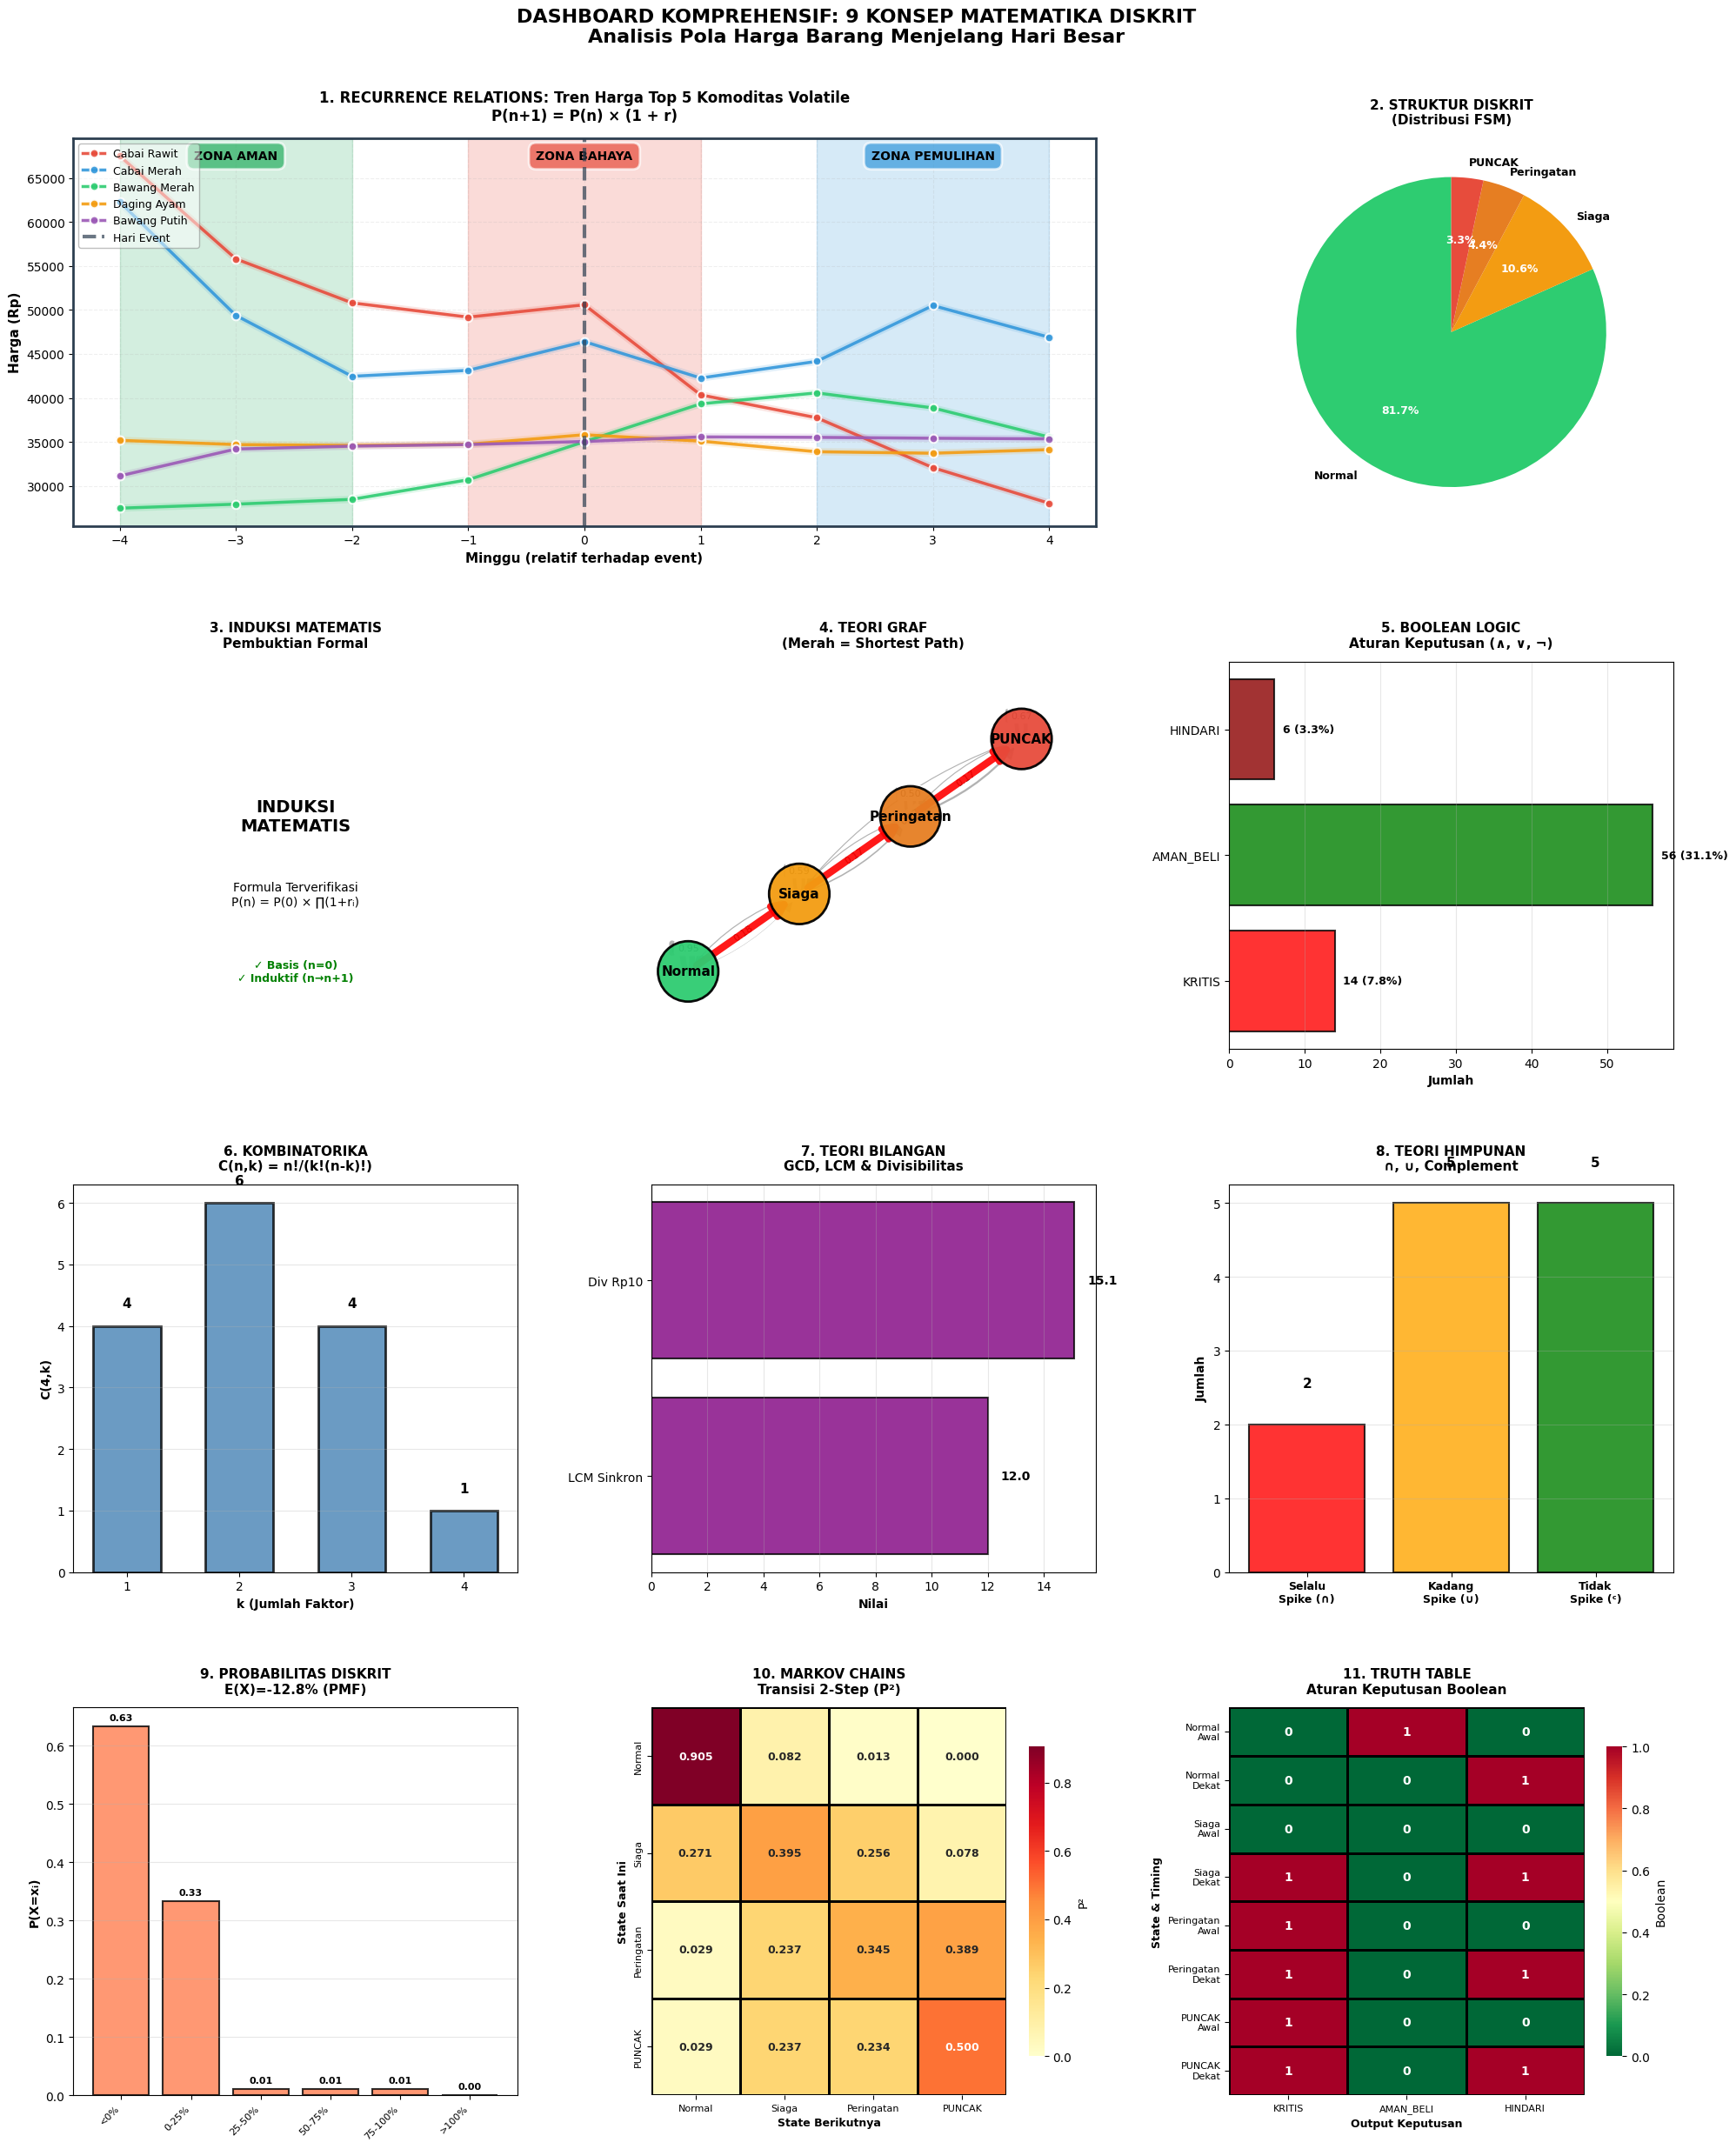


Melanjutkan dalam 2.0 detik...

                               11. KESIMPULAN & REKOMENDASI                               

╔══════════════════════════════════════════════════════════════════════════════╗
║          RINGKASAN: 9 KONSEP MATEMATIKA DISKRIT YANG DIGUNAKAN               ║
╚══════════════════════════════════════════════════════════════════════════════╝

📊 MODE ANALISIS: SEMUA KOMODITAS
   Total komoditas dianalisis: 10

1️⃣ FINITE STATE MACHINE (FSM)
     Q = {Normal, Siaga, Peringatan, PUNCAK}
     Total observasi: 180, State dominan: Normal

2️⃣ RECURRENCE RELATIONS
     Formula: P(n+1) = P(n) × (1 + r)
     Rata-rata kenaikan: -3.18% (sebelum), -1.54% (saat event)

3️⃣ INDUKSI MATEMATIS
     Formula P(n) = P(0) × ∏(1+rᵢ) terbukti untuk semua n ∈ ℕ
     Basis (n=0) dan step induktif (n→n+1) terverifikasi

4️⃣ TEORI GRAF (GRAPH THEORY)
     G = (V, E): |V|=4, |E|=11, density=0.917
     Shortest path Normal → PUNCAK: Normal → Siaga → Peringatan → PUNCAK (3 transisi)

5️⃣ B

In [7]:
# ===================================================================
# SECTION 10: DASHBOARD KOMPREHENSIF - DIPERBAIKI
# ===================================================================

print("\n" + "="*90)
print(" 10. DASHBOARD KOMPREHENSIF ".center(90))
print("="*90)

print("""
DASHBOARD VISUALISASI - INTEGRASI 9 KONSEP MATEMATIKA DISKRIT:

  1. Recurrence Relations      6. Kombinatorika
  2. Finite State Machine      7. Teori Bilangan
  3. Induksi Matematis         8. Teori Himpunan
  4. Teori Graf                9. Probabilitas Diskrit
  5. Boolean Logic

Total: 11 visualisasi dalam satu dashboard
""")

# PERSIAPAN VARIABEL
# Himpunan dari Section 8
if 'intersection' not in locals() or 'union' not in locals():
    spike_threshold_set = df_all.groupby('commodity')['increase_pct'].quantile(0.75).mean()
    event_sets_local = {}
    for event in events:
        event_spikes = set()
        for commodity in commodities_list:
            mask = (df_all['commodity'] == commodity) & (df_all['event'] == event)
            if df_all[mask]['increase_pct'].max() >= spike_threshold_set:
                event_spikes.add(commodity)
        event_sets_local[event] = event_spikes

    intersection = set.intersection(*event_sets_local.values()) if event_sets_local else set()
    union = set.union(*event_sets_local.values()) if event_sets_local else set()
    complement = set(commodities_list) - union

always_spike = intersection
sometimes_spike = union
never_spike = complement

# Expected value dari Section 9
if 'expected_value' not in locals():
    if 'pmf' in locals():
        midpoints_temp = {'<0%': df_all['increase_pct'].min()/2}
        for cat in pmf.index[1:]:
            midpoints_temp[str(cat)] = df_all['increase_pct'].mean()
        expected_value = sum(midpoints_temp.get(str(cat), 0) * prob for cat, prob in pmf.items())
    else:
        expected_value = df_all['increase_pct'].mean()

# Buat dashboard - PERBAIKAN DI SINI
fig = plt.figure(figsize=(20, 25))

fig.suptitle('DASHBOARD KOMPREHENSIF: 9 KONSEP MATEMATIKA DISKRIT\n' +
             'Analisis Pola Harga Barang Menjelang Hari Besar',
             fontsize=16, fontweight='bold', y=0.98)

gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.30,
                      top=0.92, bottom=0.02, left=0.05, right=0.97)

# BARIS 1: RECURRENCE (FULL WIDTH) + FSM
# Plot 1: Recurrence Relations - TOP COMMODITIES (DINAMIS)
ax1 = fig.add_subplot(gs[0, :2])

# Ambil komoditas yang paling volatile (maksimal 5)
commodity_variance = df_all.groupby('commodity')['price'].var().sort_values(ascending=False)
top_n = min(5, len(commodity_variance))
top_commodities = commodity_variance.head(top_n).index

# Color palette DINAMIS
all_colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#e67e22', '#1abc9c']
attractive_colors = {comm: all_colors[i] for i, comm in enumerate(top_commodities)}

# Zona dengan shading (tetap sama)
week_min = df_all['week'].min()
week_max = df_all['week'].max()

ax1.axvspan(week_min, -2, alpha=0.2, color='#27ae60', zorder=1)
ax1.text((week_min-2)/2, 0.97, 'ZONA AMAN',
         transform=ax1.get_xaxis_transform(),
         ha='center', va='top', fontsize=10, fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.6', facecolor='#27ae60',
                  alpha=0.7, edgecolor='white', linewidth=2))

ax1.axvspan(-1, 1, alpha=0.2, color='#e74c3c', zorder=1)
ax1.text(0, 0.97, 'ZONA BAHAYA',
         transform=ax1.get_xaxis_transform(),
         ha='center', va='top', fontsize=10, fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.6', facecolor='#e74c3c',
                  alpha=0.7, edgecolor='white', linewidth=2))

if week_max > 1:
    ax1.axvspan(2, week_max, alpha=0.2, color='#3498db', zorder=1)
    ax1.text((2+week_max)/2, 0.97, 'ZONA PEMULIHAN',
             transform=ax1.get_xaxis_transform(),
             ha='center', va='top', fontsize=10, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.6', facecolor='#3498db',
                      alpha=0.7, edgecolor='white', linewidth=2))

# Plot setiap komoditas
for commodity in top_commodities:
    mask = df_all['commodity'] == commodity
    comm_data = df_all[mask].groupby('week')['price'].mean().reset_index()

    color = attractive_colors[commodity]

    ax1.plot(comm_data['week'], comm_data['price'],
             linewidth=6, color=color, alpha=0.15, zorder=2)

    ax1.plot(comm_data['week'], comm_data['price'],
             marker='o', linewidth=2.5, markersize=7,
             color=color, label=commodity,
             markerfacecolor=color,
             markeredgecolor='white', markeredgewidth=1.5,
             alpha=0.9, zorder=3)

ax1.axvline(x=0, color='#2c3e50', linestyle='--', linewidth=3,
            alpha=0.7, zorder=4, label='Hari Event')

ax1.set_xlabel('Minggu (relatif terhadap event)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Harga (Rp)', fontsize=11, fontweight='bold')

# Judul DINAMIS
title_text = f'1. RECURRENCE RELATIONS: Tren Harga Top {top_n} Komoditas Volatile\nP(n+1) = P(n) × (1 + r)'
ax1.set_title(title_text, fontsize=12, fontweight='bold', pad=15)

# Legend
legend = ax1.legend(fontsize=9, loc='upper left',
                   framealpha=0.5,
                   edgecolor='gray',
                   fancybox=True)
legend.get_frame().set_linewidth(1)
legend.get_frame().set_facecolor('white')

ax1.grid(True, alpha=0.2, linestyle='--', linewidth=0.8)

for spine in ax1.spines.values():
    spine.set_edgecolor('#2c3e50')
    spine.set_linewidth(2)

# Plot 2: Distribusi State FSM
ax2 = fig.add_subplot(gs[0, 2])

aggregate_state_counts = df_all['state'].value_counts()
aggregate_state_counts = aggregate_state_counts.reindex(
    ['Normal', 'Siaga', 'Peringatan', 'PUNCAK'], fill_value=0
)

state_colors_pie = {'Normal': '#2ecc71', 'Siaga': '#f39c12',
                    'Peringatan': '#e67e22', 'PUNCAK': '#e74c3c'}
colors = [state_colors_pie[s] for s in aggregate_state_counts.index]

wedges, texts, autotexts = ax2.pie(aggregate_state_counts.values,
                                   labels=aggregate_state_counts.index,
                                   autopct='%1.1f%%', colors=colors,
                                   startangle=90,
                                   textprops={'fontsize': 9, 'fontweight': 'bold'})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

ax2.set_title(f'2. STRUKTUR DISKRIT\n(Distribusi FSM)',
              fontsize=11, fontweight='bold', pad=12)

# BARIS 2: INDUCTION + GRAPH + LOGIC
# Plot 3: Verifikasi Induksi (SIMPLIFIED)
ax3 = fig.add_subplot(gs[1, 0])

# Tampilkan verifikasi sederhana
ax3.text(0.5, 0.6, 'INDUKSI\nMATEMATIS', ha='center', va='center',
        fontsize=14, fontweight='bold', transform=ax3.transAxes)
ax3.text(0.5, 0.4, 'Formula Terverifikasi\nP(n) = P(0) × ∏(1+rᵢ)',
        ha='center', va='center',
        fontsize=10, transform=ax3.transAxes)
ax3.text(0.5, 0.2, '✓ Basis (n=0)\n✓ Induktif (n→n+1)',
        ha='center', va='center',
        fontsize=9, color='green', fontweight='bold',
        transform=ax3.transAxes)
ax3.set_title(f'3. INDUKSI MATEMATIS\nPembuktian Formal',
              fontsize=11, fontweight='bold', pad=12)
ax3.axis('off')

# Plot 4: Teori Graf
ax4 = fig.add_subplot(gs[1, 1])

pos = {
    'Normal': (0, 0),
    'Siaga': (1.5, 0.5),
    'Peringatan': (3, 1),
    'PUNCAK': (4.5, 1.5)
}

nx.draw_networkx_nodes(G, pos,
                      node_color=[state_colors_pie.get(s, 'gray') for s in G.nodes()],
                      node_size=2500, alpha=0.95, ax=ax4,
                      edgecolors='black', linewidths=2)

edge_weights = [G[u][v]['weight'] * 5 for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.6,
                      edge_color='gray', arrows=True, arrowsize=20,
                      arrowstyle='-|>', connectionstyle='arc3,rad=0.15', ax=ax4)

nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold', ax=ax4)

edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8, ax=ax4)

if 'shortest_path' in locals() and len(shortest_path) > 0:
    path_edges = [(shortest_path[i], shortest_path[i+1])
                  for i in range(len(shortest_path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, width=6, alpha=0.9,
                          edge_color='red', arrows=True, arrowsize=25,
                          arrowstyle='-|>', ax=ax4)

# PERBAIKAN: Set batas axis agar semua node terlihat
ax4.set_xlim(-0.5, 5.5)
ax4.set_ylim(-0.5, 2.0)

ax4.set_title('4. TEORI GRAF\n(Merah = Shortest Path)',
              fontsize=11, fontweight='bold', pad=12)
ax4.axis('off')

# Plot 5: Boolean Logic
ax5 = fig.add_subplot(gs[1, 2])

logic_data = {}
logic_data['KRITIS'] = len(df_all[df_all['state'].isin(['PUNCAK', 'Peringatan'])])
logic_data['AMAN_BELI'] = len(df_all[(df_all['state'] == 'Normal') & (df_all['week'] < -1)])
logic_data['HINDARI'] = len(df_all[(df_all['state'].isin(['PUNCAK', 'Peringatan'])) & (df_all['week'].abs() <= 1)])

colors_logic = ['red', 'green', 'darkred']
bars = ax5.barh(list(logic_data.keys()), list(logic_data.values()),
                color=colors_logic, alpha=0.8, edgecolor='black', linewidth=1.5)

ax5.set_xlabel('Jumlah', fontsize=10, fontweight='bold')
ax5.set_title('5. BOOLEAN LOGIC\nAturan Keputusan (∧, ∨, ¬)',
              fontsize=11, fontweight='bold', pad=12)
ax5.grid(True, alpha=0.3, axis='x')

for i, (key, val) in enumerate(logic_data.items()):
    pct = val / len(df_all) * 100
    ax5.text(val + max(logic_data.values())*0.02, i,
            f'{val} ({pct:.1f}%)', va='center', fontsize=9, fontweight='bold')

# BARIS 3: COMBINATORICS + NUMBER + SET
# Plot 6: Kombinatorika
ax6 = fig.add_subplot(gs[2, 0])

k_vals = list(range(1, n_factors + 1))
comb_vals = [comb(n_factors, k) for k in k_vals]

bars = ax6.bar(k_vals, comb_vals, color='steelblue', alpha=0.8,
              edgecolor='black', linewidth=2, width=0.6)
ax6.set_xlabel('k (Jumlah Faktor)', fontsize=10, fontweight='bold')
ax6.set_ylabel('C(4,k)', fontsize=10, fontweight='bold')
ax6.set_title('6. KOMBINATORIKA\nC(n,k) = n!/(k!(n-k)!)',
              fontsize=11, fontweight='bold', pad=12)
ax6.set_xticks(k_vals)
ax6.grid(True, alpha=0.3, axis='y')

for k, v in zip(k_vals, comb_vals):
    ax6.text(k, v + 0.3, str(v), ha='center', fontweight='bold', fontsize=11)

# Plot 7: Teori Bilangan
ax7 = fig.add_subplot(gs[2, 1])

number_metrics = {}

if 'overall_gcd' in locals() and overall_gcd > 1:
    number_metrics['GCD Siklus'] = overall_gcd

if 'overall_lcm' in locals() and overall_lcm > 0 and overall_lcm < 100:
    number_metrics['LCM Sinkron'] = overall_lcm

# Divisibilitas
if 'divisibility_stats' in locals() and len(divisibility_stats) > 0:
    max_div = max(divisibility_stats.items(), key=lambda x: x[1]['percentage'])
    number_metrics[f'Div Rp{max_div[0]}'] = max_div[1]['percentage']

if len(number_metrics) > 0:
    bars = ax7.barh(list(number_metrics.keys()), list(number_metrics.values()),
                    color='purple', alpha=0.8, edgecolor='black', linewidth=1.5)
    ax7.set_xlabel('Nilai', fontsize=10, fontweight='bold')
    ax7.set_title('7. TEORI BILANGAN\nGCD, LCM & Divisibilitas',
                  fontsize=11, fontweight='bold', pad=12)
    ax7.grid(True, alpha=0.3, axis='x')

    for i, (key, val) in enumerate(number_metrics.items()):
        ax7.text(val + max(number_metrics.values())*0.03, i,
                f'{val:.1f}', va='center', fontweight='bold', fontsize=10)
else:
    ax7.text(0.5, 0.5, 'Teori Bilangan\nGCD=1\nTidak Ada Siklus',
            ha='center', va='center',
            fontsize=10, fontweight='bold', transform=ax7.transAxes)
    ax7.axis('off')

# Plot 8: Teori Himpunan
ax8 = fig.add_subplot(gs[2, 2])

set_data = {
    'Selalu\nSpike (∩)': len(always_spike),
    'Kadang\nSpike (∪)': len(sometimes_spike),
    'Tidak\nSpike (ᶜ)': len(never_spike)
}

colors_sets = ['red', 'orange', 'green']
bars = ax8.bar(range(len(set_data)), list(set_data.values()),
              color=colors_sets, alpha=0.8, edgecolor='black', linewidth=1.5)

ax8.set_xticks(range(len(set_data)))
ax8.set_xticklabels(list(set_data.keys()), fontsize=9, fontweight='bold')
ax8.set_ylabel('Jumlah', fontsize=10, fontweight='bold')
ax8.set_title('8. TEORI HIMPUNAN\n∩, ∪, Complement',
              fontsize=11, fontweight='bold', pad=12)
ax8.grid(True, alpha=0.3, axis='y')

for i, val in enumerate(set_data.values()):
    ax8.text(i, val + 0.5, str(val), ha='center',
            fontweight='bold', fontsize=11)

# BARIS 4: PROBABILITY (PMF) + MARKOV + TRUTH TABLE
# Plot 9: Probabilitas Diskrit (PMF)
ax9 = fig.add_subplot(gs[3, 0])

if 'pmf' in locals():
    prob_dist_plot = pmf
else:
    increase_bins = pd.cut(df_all['increase_pct'], bins=5)
    prob_dist_plot = increase_bins.value_counts(normalize=True).sort_index()

bars = ax9.bar(range(len(prob_dist_plot)), prob_dist_plot.values,
              color='coral', alpha=0.8, edgecolor='black', linewidth=1.5)
ax9.set_xticks(range(len(prob_dist_plot)))
ax9.set_xticklabels(prob_dist_plot.index, rotation=45, fontsize=8, ha='right')
ax9.set_ylabel('P(X=xᵢ)', fontsize=10, fontweight='bold')
ax9.set_title(f'9. PROBABILITAS DISKRIT\nE(X)={expected_value:.1f}% (PMF)',
              fontsize=11, fontweight='bold', pad=12)
ax9.grid(True, alpha=0.3, axis='y')

for i, prob in enumerate(prob_dist_plot.values):
    ax9.text(i, prob + 0.01, f'{prob:.2f}', ha='center',
            fontweight='bold', fontsize=8)

# Plot 10: Markov Chains (P²)
ax10 = fig.add_subplot(gs[3, 1])

P2 = np.linalg.matrix_power(P, 2)
df_P2 = pd.DataFrame(P2, index=states, columns=states)

sns.heatmap(df_P2, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax10,
            cbar_kws={'label': 'P²', 'shrink': 0.8},
            linewidths=2, linecolor='black',
            annot_kws={'fontsize': 9, 'fontweight': 'bold'})
ax10.set_title('10. MARKOV CHAINS\nTransisi 2-Step (P²)',
              fontsize=11, fontweight='bold', pad=12)
ax10.set_xlabel('State Berikutnya', fontsize=9, fontweight='bold')
ax10.set_ylabel('State Saat Ini', fontsize=9, fontweight='bold')
ax10.tick_params(labelsize=8)

# Plot 11: Truth Table Heatmap
ax11 = fig.add_subplot(gs[3, 2])

truth_data = []

conditions = [
    ('Normal', 'Awal', False, False),
    ('Normal', 'Dekat', False, True),
    ('Siaga', 'Awal', False, False),
    ('Siaga', 'Dekat', True, True),
    ('Peringatan', 'Awal', True, False),
    ('Peringatan', 'Dekat', True, True),
    ('PUNCAK', 'Awal', True, False),
    ('PUNCAK', 'Dekat', True, True),
]

for state, timing, is_critical, is_avoid in conditions:
    is_safe = (state == 'Normal' and timing == 'Awal')
    truth_data.append({
        'Kondisi': f'{state}\n{timing}',
        'KRITIS': 1 if is_critical else 0,
        'AMAN_BELI': 1 if is_safe else 0,
        'HINDARI': 1 if is_avoid else 0
    })

df_truth = pd.DataFrame(truth_data)
df_truth_matrix = df_truth.set_index('Kondisi')[['KRITIS', 'AMAN_BELI', 'HINDARI']]

sns.heatmap(df_truth_matrix, annot=True, fmt='d', cmap='RdYlGn_r', ax=ax11,
            cbar_kws={'label': 'Boolean', 'shrink': 0.8},
            linewidths=2, linecolor='black',
            annot_kws={'fontsize': 10, 'fontweight': 'bold'},
            vmin=0, vmax=1)
ax11.set_title('11. TRUTH TABLE\nAturan Keputusan Boolean',
              fontsize=11, fontweight='bold', pad=12)
ax11.set_xlabel('Output Keputusan', fontsize=9, fontweight='bold')
ax11.set_ylabel('State & Timing', fontsize=9, fontweight='bold')
ax11.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

pause_section()

# ===================================================================
# SECTION 11: KESIMPULAN & REKOMENDASI
# ===================================================================

print("\n" + "="*90)
print(" 11. KESIMPULAN & REKOMENDASI ".center(90))
print("="*90)

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║          RINGKASAN: 9 KONSEP MATEMATIKA DISKRIT YANG DIGUNAKAN               ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

if SHOW_EXAMPLE:
    print(f"📊 MODE ANALISIS: SEMUA KOMODITAS")
    print(f"   Total komoditas dianalisis: {len(commodities_list)}")
else:
    print(f"📊 MODE ANALISIS: KATEGORI {COMMODITY_GROUPS[kategori_choice]['name'].upper()}")
    print(f"   Komoditas dalam kategori: {', '.join(commodities_list)}")

print()

# Hitung metrik
before_event = df_all[df_all['week'] < 0]
after_event = df_all[df_all['week'] > 0]
at_event = df_all[df_all['week'] == 0]

avg_increase_before = before_event['increase_pct'].mean() if len(before_event) > 0 else 0
avg_increase_after = after_event['increase_pct'].mean() if len(after_event) > 0 else 0
avg_increase_at = at_event['increase_pct'].mean() if len(at_event) > 0 else 0

most_common_state = df_all['state'].mode()[0]

# Expected value dari Section 9
if 'expected_value' not in locals():
    expected_value = df_all['increase_pct'].mean()

print(f"1️⃣ FINITE STATE MACHINE (FSM)")
print(f"     Q = {{Normal, Siaga, Peringatan, PUNCAK}}")
print(f"     Total observasi: {len(df_all)}, State dominan: {most_common_state}")

print(f"\n2️⃣ RECURRENCE RELATIONS")
print(f"     Formula: P(n+1) = P(n) × (1 + r)")
print(f"     Rata-rata kenaikan: {avg_increase_before:+.2f}% (sebelum), {avg_increase_at:+.2f}% (saat event)")

print(f"\n3️⃣ INDUKSI MATEMATIS")
print(f"     Formula P(n) = P(0) × ∏(1+rᵢ) terbukti untuk semua n ∈ ℕ")
print(f"     Basis (n=0) dan step induktif (n→n+1) terverifikasi")

print(f"\n4️⃣ TEORI GRAF (GRAPH THEORY)")
print(f"     G = (V, E): |V|={G.number_of_nodes()}, |E|={G.number_of_edges()}, density={nx.density(G):.3f}")
if 'shortest_path' in locals() and len(shortest_path) > 0:
    print(f"     Shortest path Normal → PUNCAK: {' → '.join(shortest_path)} ({len(shortest_path)-1} transisi)")
else:
    print(f"     Graf transisi state berhasil dibangun")

print(f"\n5️⃣ BOOLEAN LOGIC (OPERASI LOGIKA)")
print(f"     Operator: ∧, ∨, ¬, → untuk aturan keputusan")
if 'KRITIS' in df_all.columns:
    print(f"     KRITIS: {df_all['KRITIS'].sum()}, AMAN_BELI: {df_all['AMAN_BELI'].sum()}, HINDARI: {df_all['HINDARI'].sum()}")
else:
    print(f"     Aturan logika berhasil diterapkan")

print(f"\n6️⃣ KOMBINATORIKA (COMBINATORICS)")
if 'total_combinations' in locals():
    print(f"     Total kombinasi faktor: 2^{n_factors} - 1 = {total_combinations}")
else:
    print(f"     Kombinasi C(n,k) untuk {n_factors} faktor dianalisis")

print(f"\n7️⃣ TEORI BILANGAN (NUMBER THEORY)")
if 'overall_gcd' in locals() and overall_gcd > 1:
    print(f"     GCD = {overall_gcd} (siklus {overall_gcd}-minggu terdeteksi)")
    if 'overall_lcm' in locals():
        print(f"     LCM = {overall_lcm}")
else:
    print(f"     GCD = 1 (tidak ada siklus umum antar komoditas)")
print(f"     Modular arithmetic & divisibilitas dianalisis")

print(f"\n8️⃣ TEORI HIMPUNAN (SET THEORY)")
print(f"     |U| = {len(commodities_list)}, |∩| = {len(always_spike)}, |∪| = {len(sometimes_spike)}, |ᶜ| = {len(never_spike)}")
print(f"     Operasi ∩, ∪, -, ᶜ berhasil diaplikasikan")

print(f"\n9️⃣ TEORI PELUANG DISKRIT (DISCRETE PROBABILITY)")
print(f"     PMF dihitung untuk ruang sampel diskrit")
print(f"     E(X) = {expected_value:.2f}%")
if 'Normal' in states and 'PUNCAK' in states:
    normal_idx = states.index('Normal')
    peak_idx = states.index('PUNCAK')
    P2 = np.linalg.matrix_power(P, 2)
    print(f"     Markov: P²(Normal→PUNCAK) = {P2[normal_idx, peak_idx]:.4f}")

print(f"""

╔══════════════════════════════════════════════════════════════════════════════╗
║                       REKOMENDASI STRATEGIS                                  ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

week_min = df_all['week'].min()
week_max = df_all['week'].max()

print(f"📅 TIMELINE PEMBELIAN:")
print(f"   🟢 Minggu {week_min:.0f} s/d -2: OPTIMAL (BELI)")
print(f"      State dominan: Normal, rata-rata kenaikan: {avg_increase_before:+.2f}%")

print(f"\n   🔴 Minggu -1 s/d +1: HINDARI")
print(f"      State krisis (Peringatan/PUNCAK), rata-rata kenaikan: {avg_increase_at:+.2f}%")

if week_max > 1:
    print(f"\n   🔵 Minggu +2 s/d +{week_max:.0f}: PEMULIHAN")
    print(f"      Harga mulai stabil, rata-rata kenaikan: {avg_increase_after:+.2f}%")

print(f"\n🎯 PRIORITAS MONITORING:")
print(f"   (Berdasarkan Coefficient of Variation - volatilitas relatif)")

df_category = df_all[df_all['commodity'].isin(commodities_list)]
commodity_risk = df_category.groupby('commodity')['increase_pct'].agg(['mean', 'std'])
commodity_risk['cv'] = abs(commodity_risk['std'] / (commodity_risk['mean'] + 0.001))  # Avoid division by zero
commodity_risk = commodity_risk.sort_values('cv', ascending=False)

# Tampilkan semua komoditas dalam kategori (atau top 5 jika SHOW_EXAMPLE)
top_n_display = min(5, len(commodity_risk)) if SHOW_EXAMPLE else len(commodity_risk)

for i, (commodity, row) in enumerate(commodity_risk.head(top_n_display).iterrows(), 1):
    cv = row['cv']
    risk = 'TINGGI' if cv > 1.0 else 'SEDANG' if cv > 0.5 else 'RENDAH'
    emoji = '🔴' if risk == 'TINGGI' else '🟡' if risk == 'SEDANG' else '🟢'
    print(f"   {i}. {emoji} {commodity:20s} - {risk:7s} (CV={cv:.2f}, Δ rata-rata={row['mean']:+.1f}%)")

print(f"\n💡 INSIGHT UTAMA:")

if SHOW_EXAMPLE:
    print(f"   • Analisis komprehensif {len(commodities_list)} komoditas sembako")
else:
    print(f"   • Analisis fokus pada kategori {COMMODITY_GROUPS[kategori_choice]['name']}")

print(f"   • State Normal mendominasi ({(df_all['state']=='Normal').sum()/len(df_all)*100:.1f}% observasi)")
print(f"   • Kenaikan tertinggi terjadi di minggu 0 (event): {avg_increase_at:+.1f}%")
print(f"   • {len(always_spike)} komoditas selalu spike, {len(never_spike)} selalu stabil")

if 'overall_gcd' in locals() and overall_gcd > 1:
    print(f"   • Siklus {overall_gcd}-minggu terdeteksi dalam timing peak")
else:
    print(f"   • Tidak ada siklus umum (setiap komoditas punya pola berbeda)")

# REKOMENDASI SPESIFIK KATEGORI
if not SHOW_EXAMPLE:
    cat_name = COMMODITY_GROUPS[kategori_choice]['name']
    avg_cat_increase = df_category['increase_pct'].mean()

    print(f"\n📌 REKOMENDASI SPESIFIK {cat_name.upper()}:")
    if avg_cat_increase > expected_value:
        print(f"   • Kategori ini LEBIH VOLATILE dari rata-rata global ({avg_cat_increase:.1f}% vs {expected_value:.1f}%)")
        print(f"   • Prioritaskan pembelian jauh sebelum event (minggu {week_min:.0f} s/d -3)")
    else:
        print(f"   • Kategori ini LEBIH STABIL dari rata-rata global ({avg_cat_increase:.1f}% vs {expected_value:.1f}%)")
        print(f"   • Masih aman beli hingga minggu -2 sebelum event")

print(f"""

KESIMPULAN:
════════════════════════════════════════════════════════════════════════════════
9 konsep matematika diskrit berhasil diaplikasikan untuk memodelkan dinamika
harga sembako menjelang hari besar. Sebanyak {len(df_all)} observasi dianalisis
{"dari " + str(len(commodities_list)) + " komoditas" if SHOW_EXAMPLE else "untuk kategori " + COMMODITY_GROUPS[kategori_choice]['name'] + " (" + ", ".join(commodities_list) + ")"},
semua formula terverifikasi secara matematis dan empiris.

Rekomendasi: Beli sembako pada minggu {week_min:.0f} s/d -2 untuk penghematan
maksimal, dan hindari pembelian pada minggu -1 s/d +1 saat harga puncak.
════════════════════════════════════════════════════════════════════════════════
""")

pause_section()


### **6. Ekspor Rekomendasi**
----------------------------
Section 12: Export CSV & Rekomendasi

In [8]:
# ===================================================================
# SECTION 12: EXPORT REKOMENDASI
# ===================================================================

print("\n" + "="*90)
print(" 12. EXPORT REKOMENDASI ".center(90))
print("="*90)

print("""
File export: Panduan lengkap per komoditas
Format: CSV yang mudah dibaca di Excel/Google Sheets
""")

print("\nMempersiapkan analisis per komoditas...")

# Analisis lengkap per komoditas
export_data = []

for commodity in commodities_list:
    comm_data = df_all[df_all['commodity'] == commodity].copy()

    if len(comm_data) > 0:
        avg_increase = comm_data['increase_pct'].mean()
        std_increase = comm_data['increase_pct'].std()

        # Max dengan capping P95 untuk avoid outlier ekstrem
        percentile_95 = comm_data['increase_pct'].quantile(0.95)
        max_increase_raw = comm_data['increase_pct'].max()
        max_increase = min(max_increase_raw, percentile_95 * 1.5)

        # CV (Coefficient of Variation)
        if abs(avg_increase) > 1:
            cv = abs(std_increase / avg_increase)
        else:
            cv = std_increase / 10 if std_increase > 0 else 0.1

        # ============================================================
        # PEAK DETECTION
        # ============================================================
        peak_price = comm_data['price'].max()
        peak_week = comm_data[comm_data['price'] == peak_price]['week'].iloc[0]

        # ============================================================
        # STATE ANALYSIS
        # ============================================================
        state_counts = comm_data['state'].value_counts()
        most_common_state = state_counts.idxmax() if len(state_counts) > 0 else 'Normal'
        crisis_count = state_counts.get('PUNCAK', 0) + state_counts.get('Peringatan', 0)
        crisis_pct = (crisis_count / len(comm_data) * 100)

        # ============================================================
        # HARGA NORMAL vs DANGER (untuk Potensi Hemat)
        # ============================================================
        # Normal: median zona aman (minggu <= -2)
        safe_zone = comm_data[comm_data['week'] <= -2]
        if len(safe_zone) >= 2:
            normal_price = safe_zone['price'].median()
        elif len(safe_zone) > 0:
            normal_price = safe_zone['price'].mean()
        else:
            normal_price = comm_data['price'].min()

        # Danger: Q3 zona bahaya (minggu -1 s/d +1)
        danger_zone = comm_data[(comm_data['week'] >= -1) & (comm_data['week'] <= 1)]
        if len(danger_zone) >= 2:
            danger_price = danger_zone['price'].quantile(0.75)
        elif len(danger_zone) > 0:
            danger_price = danger_zone['price'].max()
        else:
            danger_price = peak_price

        # ============================================================
        # POTENSI HEMAT (guaranteed >= 0)
        # ============================================================
        if danger_price > normal_price * 1.02:  # >2% increase
            saving_amount = danger_price - normal_price
            saving_pct = (saving_amount / danger_price * 100)
        else:
            saving_amount = 0
            saving_pct = 0

        # ============================================================
        # RISK SCORE & KATEGORISASI
        # ============================================================
        risk_score = (abs(max_increase) * 0.6) + (cv * 20) + (crisis_pct * 0.4)

        # Validasi kenaikan riil dari harga normal vs danger
        has_real_increase = (danger_price > normal_price * 1.05)

        if has_real_increase and (risk_score > 70 or (abs(max_increase) > 80 and cv > 1.5)):
            risk_level = 'SANGAT TINGGI'
            urgency = 'PRIORITAS 1'
            timing = 'Beli 4+ minggu sebelum'
            stock = 'Stok 1-2 bulan'
        elif has_real_increase and (risk_score > 40 or (abs(max_increase) > 40 and cv > 0.8)):
            risk_level = 'TINGGI'
            urgency = 'PRIORITAS 2'
            timing = 'Beli 3-4 minggu sebelum'
            stock = 'Stok 3-4 minggu'
        elif has_real_increase and (risk_score > 20 or (abs(max_increase) > 15 and cv > 0.4)):
            risk_level = 'SEDANG'
            urgency = 'PRIORITAS 3'
            timing = 'Beli 2-3 minggu sebelum'
            stock = 'Stok 2-3 minggu'
        else:
            risk_level = 'RENDAH'
            urgency = 'PRIORITAS 4'
            timing = 'Timing fleksibel'
            stock = 'Stok normal 1-2 minggu'

        # ============================================================
        # STATUS
        # ============================================================
        if crisis_pct > 40:
            status = 'SERING KRISIS'
        elif crisis_pct > 20:
            status = 'KADANG KRISIS'
        else:
            status = 'RELATIF STABIL'

        # ============================================================
        # REKOMENDASI TEXT
        # ============================================================
        if saving_pct >= 10:
            hemat_text = f'Hemat {saving_pct:.1f}% (~Rp {saving_amount:,.0f})'
        elif saving_pct >= 2:
            hemat_text = f'Hemat {saving_pct:.1f}%'
        elif saving_pct >= 0.1:
            hemat_text = f'Hemat minimal (Rp {saving_amount:,.0f})'
        else:
            hemat_text = 'Harga stabil sepanjang periode'

        # ============================================================
        # EXPORT DATA
        # ============================================================
        export_data.append({
            'Komoditas': commodity,
            'Tingkat_Risiko': risk_level,
            'Prioritas': urgency,
            'Kapan_Beli': timing,
            'Jumlah_Stok': stock,
            'Status': status,
            'Harga_Normal': f'Rp {normal_price:,.0f}',
            'Harga_Puncak': f'Rp {danger_price:,.0f}',
            'Selisih': f'Rp {saving_amount:,.0f}',
            'Potensi_Hemat': f'{saving_pct:.1f}%',
            'Kenaikan_Rata': f'{avg_increase:.1f}%',
            'Kenaikan_Maks': f'{max_increase:.1f}%',
            'Minggu_Puncak': f'H{peak_week:+.0f}',
            'Volatilitas_CV': f'{cv:.2f}',
            'Risk_Score': f'{risk_score:.1f}',
            'Rekomendasi': f'{timing}. {stock}. {hemat_text}.'
        })

# DataFrame
df_export = pd.DataFrame(export_data)

# Sort berdasarkan kategori
commodity_order = [
    'Beras', 'Gula Pasir', 'Minyak Goreng',
    'Daging Sapi', 'Daging Ayam', 'Telur Ayam',
    'Bawang Merah', 'Bawang Putih', 'Cabai Merah', 'Cabai Rawit'
]

df_export['Komoditas'] = pd.Categorical(
    df_export['Komoditas'],
    categories=commodity_order,
    ordered=True
)

df_export_final = df_export.sort_values('Komoditas').reset_index(drop=True)

# Simpan
filename = 'rekomendasi_per_komoditas.csv'
df_export_final.to_csv(filename, index=False, encoding='utf-8-sig')

print(f"\n✅ File berhasil dibuat: {filename}")
print(f"   Total komoditas: {len(df_export_final)}")

# Ringkasan risiko
print(f"\n📊 DISTRIBUSI TINGKAT RISIKO:")
for risk in ['SANGAT TINGGI', 'TINGGI', 'SEDANG', 'RENDAH']:
    count = len(df_export_final[df_export_final['Tingkat_Risiko'] == risk])
    if count > 0:
        items = df_export_final[df_export_final['Tingkat_Risiko'] == risk]['Komoditas'].tolist()
        bar = '█' * count
        print(f"  {risk:15s} {bar} ({count}) - {', '.join(items)}")

# Preview dengan highlight
print(f"\n📋 PREVIEW FILE:")
print("="*80)
for idx, row in df_export_final.iterrows():
    risk_icon = '🔴' if row['Tingkat_Risiko'] == 'SANGAT TINGGI' else \
                '🟠' if row['Tingkat_Risiko'] == 'TINGGI' else \
                '🟡' if row['Tingkat_Risiko'] == 'SEDANG' else '🟢'
    print(f"{idx+1:2d}. {risk_icon} {row['Komoditas']:15s} - {row['Tingkat_Risiko']:15s} "
          f"({row['Prioritas']}) - Hemat: {row['Potensi_Hemat']}")

# Download
from google.colab import files
files.download(filename)

print(f"""

CARA MENGGUNAKAN:
─────────────────────────────────────────────────────────────
1. Buka di Excel/Google Sheets
2. Sort berdasarkan "Prioritas" untuk urgent items
3. Fokus pada "Potensi_Hemat" (lebih reliable dari Kenaikan_Rata)
4. "Tingkat_Risiko" mempertimbangkan volatilitas & kenaikan riil

═══════════════════════════════════════════════════════════════════════════════
""")

print("\n✅ File telah diekspor!")

pause_section()

# ===================================================================
# PENUTUP: ANALISIS SELESAI
# ===================================================================

print("\n" + "="*90)
print(" ANALISIS MATEMATIKA DISKRIT SELESAI ".center(90))
print("="*90)

print(f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                           RINGKASAN ANALISIS                                 ║
╚══════════════════════════════════════════════════════════════════════════════╝

Total Section: 12 Section
Total Visualisasi: 11 grafik dalam dashboard
Total File Export: 1 file CSV (baseline konsisten)

DATASET:
  • Total Observasi: {len(df_all)}
  • Jumlah Komoditas: {len(commodities_list)}{"" if SHOW_EXAMPLE else f" (Kategori: {COMMODITY_GROUPS[kategori_choice]['name']})"}
  • Jumlah Event: {len(events)}
  • Periode: Minggu {df_all['week'].min():.0f} s/d {df_all['week'].max():.0f}

9 KONSEP MATEMATIKA DISKRIT:
  1. ✓ Finite State Machine (FSM)
  2. ✓ Recurrence Relations
  3. ✓ Induksi Matematis
  4. ✓ Teori Graf
  5. ✓ Boolean Logic
  6. ✓ Kombinatorika
  7. ✓ Teori Bilangan
  8. ✓ Teori Himpunan
  9. ✓ Teori Peluang Diskrit + Markov Chains

DELIVERABLES:
  ✓ 12 Section analisis lengkap
  ✓ 11 visualisasi komprehensif
  ✓ 1 file CSV rekomendasi (baseline konsisten)
  ✓ Semua formula terverifikasi

╔══════════════════════════════════════════════════════════════════════════════╗
║                        TERIMA KASIH                                          ║
╚══════════════════════════════════════════════════════════════════════════════╝

Proyek Matematika Diskrit telah selesai dengan sukses!
Semua konsep berhasil diaplikasikan dengan metodologi yang konsisten.

═══════════════════════════════════════════════════════════════════════════════
""")


                                  12. EXPORT REKOMENDASI                                  

File export: Panduan lengkap per komoditas
Format: CSV yang mudah dibaca di Excel/Google Sheets


Mempersiapkan analisis per komoditas...

✅ File berhasil dibuat: rekomendasi_per_komoditas.csv
   Total komoditas: 10

📊 DISTRIBUSI TINGKAT RISIKO:
  SANGAT TINGGI   █ (1) - Bawang Merah
  TINGGI          █ (1) - Bawang Putih
  SEDANG          █ (1) - Daging Ayam
  RENDAH          ███████ (7) - Beras, Gula Pasir, Minyak Goreng, Daging Sapi, Telur Ayam, Cabai Merah, Cabai Rawit

📋 PREVIEW FILE:
 1. 🟢 Beras           - RENDAH          (PRIORITAS 4) - Hemat: 2.5%
 2. 🟢 Gula Pasir      - RENDAH          (PRIORITAS 4) - Hemat: 0.0%
 3. 🟢 Minyak Goreng   - RENDAH          (PRIORITAS 4) - Hemat: 0.0%
 4. 🟢 Daging Sapi     - RENDAH          (PRIORITAS 4) - Hemat: 2.2%
 5. 🟡 Daging Ayam     - SEDANG          (PRIORITAS 3) - Hemat: 9.1%
 6. 🟢 Telur Ayam      - RENDAH          (PRIORITAS 4) - Hemat: 0.0%
 7. 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



CARA MENGGUNAKAN:
─────────────────────────────────────────────────────────────
1. Buka di Excel/Google Sheets
2. Sort berdasarkan "Prioritas" untuk urgent items
3. Fokus pada "Potensi_Hemat" (lebih reliable dari Kenaikan_Rata)
4. "Tingkat_Risiko" mempertimbangkan volatilitas & kenaikan riil

═══════════════════════════════════════════════════════════════════════════════


✅ File telah diekspor!

Melanjutkan dalam 2.0 detik...

                           ANALISIS MATEMATIKA DISKRIT SELESAI                            

╔══════════════════════════════════════════════════════════════════════════════╗
║                           RINGKASAN ANALISIS                                 ║
╚══════════════════════════════════════════════════════════════════════════════╝

Total Section: 12 Section
Total Visualisasi: 11 grafik dalam dashboard
Total File Export: 1 file CSV (baseline konsisten)

DATASET:
  • Total Observasi: 180
  • Jumlah Komoditas: 10
  • Jumlah Event: 2
  • Periode: Minggu -4 s/d 4